In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import random

seed = 42

In [ ]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(0)

In [ ]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    
    global x_scaler
    global y_scaler
    
    #x_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [ ]:
class History:
    def __init__(self):
        self.history = {}


class LinearLearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_init, lr_final, epochs, last_epoch=-1):
        self.lr_init = lr_init
        self.lr_final = lr_final
        self.epochs = epochs
        super().__init__(optimizer, last_epoch=last_epoch)
    
    def step(self):
        self.last_epoch += 1
        epoch = self.last_epoch
        if epoch < self.epochs:
            alpha = epoch / self.epochs
            lr = self.lr_init * (1 - alpha) + alpha*self.lr_final
        else:
            lr = self.lr_final
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()
    
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        self.reg_method = reg_method
        self.lr_decay = config["learning_rate_decay"]        
        
        
        if reg_method != None:
            value = config["regularization"]["value"]
            self.reg_value = value
        
        self.task = task
        self.model = nn.Sequential()
                
        units = config["units_1"]
        activation = get_activation_function(config["activations_1"])
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        self.model.add_module("activations_1", activation)
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(2, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.uniform_(param, self.min, self.max)
                if 'bias' in name:
                    nn.init.uniform_(param, self.min, self.max)

            
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.normal_(param, self.mean, self.std)
                if 'bias' in name:
                    nn.init.normal_(param, self.mean, self.std)
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
        
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, self.mean, self.std)
            torch.nn.init.normal_(m.bias, self.mean, self.std)
            # m.bias.data.fill_(0.01)
            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
        
        
    def get_regularization_term(self):
        
        if self.reg_method != None:
            
            value = self.reg_value
            p = 1 if self.reg_method == "l1" else 2
            reg = 0
            
            for param in self.model.parameters():
                reg += torch.linalg.norm(param, p)
                
            reg *= value
            
            return reg
        
        return 0
            
        
        
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        if self.lr_decay != None:
            decay_epochs = self.lr_decay["epochs"]
            lr_final = self.lr_decay["lr_final"]
            lr_init = self.lr
            scheduler = LinearLearningRateScheduler(optimizer, lr_init, lr_final, decay_epochs)
            return [optimizer], [scheduler]
            
        return optimizer
    
    
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        reg = self.get_regularization_term()
        loss = self.compute_loss(y_pred, y) + reg
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("hidden_layers")
    keys.remove("trials_final")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_final"] = params["trials_final"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    early_stopping = config["early_stopping"]
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    
    layers_list = params["hidden_layers"]
        
    layers_params_confs = []
    
    for layers in layers_list:
        
        layers_conf = {}
        
        for i in range(len(layers)):
            
            units, activation = layers[i]
            
            layers_conf[f"units_{i+1}"] = units
            layers_conf[f"activations_{i+1}"] = activation
            
        layers_params_confs.append(layers_conf)
        
    
    new_configurations = []
    
    
    for conf in configurations:
        
        for layers_conf in layers_params_confs:
            
            new_conf = conf
            new_conf.update(layers_conf)
            new_configurations.append(new_conf)
            
    
    
    
    '''layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))'''
                
    return new_configurations



def get_configurations(params):
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    return layers_confs


def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config):  
    
    if batch_size is None:
        batch_size_train = x_train.shape[0]
        batch_size_val = x_val.shape[0]
    else:
        batch_size_train = batch_size
        batch_size_val = batch_size
        
    
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size_train)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size_val)
    
    callbacks = get_callbacks(config)
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=1, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
            
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the mean metrics among the trials
        # med_idx = median_index(trials_val_loss)
        # med_val_loss = trials_val_loss[med_idx]
        # med_train_loss = trials_train_loss[med_idx]
        # med_val_acc = trials_val_acc[med_idx]
        # med_train_acc = trials_train_acc[med_idx]
        med_val_loss = np.mean(trials_val_loss)
        med_train_loss = np.mean(trials_train_loss)
        med_val_acc = np.mean(trials_val_acc)
        med_train_acc = np.mean(trials_train_acc)
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                                    
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_final"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_final"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            torch.save(model, f"./../models/pytorch_model_{trial}.pt")
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    
    med_model = models[med_idx]
    
    
    if task == "regression":
        
        
        y_pred = model(torch.from_numpy(x_train).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_train  = y_scaler.inverse_transform(y_train)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_train  = torch.from_numpy(y_train).to(torch.float32)
        
        mse_train = mse(y_train, y_pred)
        mee_train = mee(y_train, y_pred)

        print(f"\nTraining MSE: {mse_train}")
        print(f"Training MEE: {mee_train}")
        
        y_pred = model(torch.from_numpy(x_val).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_val  = y_scaler.inverse_transform(y_val)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_val  = torch.from_numpy(y_val).to(torch.float32)
        
        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    for trial in range(trials):
        if trial != med_idx:
            os.system(f"rm ./../models/pytorch_model_{trial}.pt")
            
    os.system(f"mv ./../models/pytorch_model_{med_idx}.pt ./../models/pytorch_model.pt")
    
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss

    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

# ML Cup

In [ ]:
x_train, y_train, _, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)

(1194, 9) (1194, 2)


In [ ]:
params = {
    "task": "regression",
    "trials_train": 1,
    "trials_final": 5,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.01
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],
    "batch_size": [16],
    "nesterov": False,
    "momentum": [0.1, 0.2, 0.3, 0.4],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.001, 0.0001, 0.00001]
        }
    ],
    "hidden_layers": [ 
        [(10, "tanh"), (10, "relu"), (10, "tanh")],
        [(25, "tanh"), (25, "relu"), (25, "tanh")],
        [(50, "tanh"), (50, "relu"), (50, "tanh")],
        [(30, "tanh"), (30, "relu")],
        [(50, "tanh"), (50, "relu")]
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activations_2': 'relu', 'units_3': 50, 'activations_3': 'tanh'}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Fold 1/4 mean val_loss: 0.0812971666455268, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1038310304284095, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2999971210956573, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3051860928535461, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Fold 2/4 mean val_loss: 0.1117793843150138, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1031876131892204, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3384338021278381, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3050142526626587, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 3/4 mean val_loss: 0.0943222194910049, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1044812649488449, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3267695605754852, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3044110834598541, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Fold 4/4 mean val_loss: 0.0908473208546638, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1044650599360466, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3293020725250244, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005692660808563, train_mee 0.0

Mean val_loss: 0.09456152282655232, std val_loss: 0.011025543767852673
Mean train_loss: 0.10399124212563035, std train_loss: 0.0005329429941608618
Mean val_mee: 0.3236256390810012, std val_mee: 0.014315155378246243
Mean train_mee: 0.3236256390810012, std train_mee: 0.001884584464041817



Testing configuration 2/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Fold 1/4 mean val_loss: 0.1019281595945358, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0979729145765304, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3331324458122253, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2991163432598114, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 2/4 mean val_loss: 0.110637791454792, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0992816463112831, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3562965095043182, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2946542203426361, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Fold 3/4 mean val_loss: 0.067453846335411, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1088850349187851, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2907593548297882, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3124512135982513, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 4/4 mean val_loss: 0.088929109275341, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1036050915718078, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3126570284366607, std val_mee 0.0
Fold 4/4 mean train_mee: 0.305928498506546, train_mee 0.0

Mean val_loss: 0.09223722666501996, std val_loss: 0.016260800617227594
Mean train_loss: 0.1024361718446016, std train_loss: 0.004266904763981966
Mean val_mee: 0.3232113346457481, std val_mee: 0.02427746699992817
Mean train_mee: 0.3232113346457481, std train_mee: 0.006757046767087798



Testing configuration 3/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activa

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 1/4 mean val_loss: 0.0886260941624641, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1050394773483276, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3111140131950378, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3079663813114166, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Fold 2/4 mean val_loss: 0.0941572412848472, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1048547700047493, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3294037282466888, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3075598776340484, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


Fold 3/4 mean val_loss: 0.0699122175574302, std val_loss 0.0
Fold 3/4 mean train_loss: 0.106994941830635, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2911337614059448, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3110593855381012, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Fold 4/4 mean val_loss: 0.1130127981305122, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0970646068453788, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3552088439464569, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2911465466022491, train_mee 0.0

Mean val_loss: 0.09142708778381342, std val_loss: 0.015363364177774804
Mean train_loss: 0.10348844900727268, std train_loss: 0.003802425608217664
Mean val_mee: 0.3217150866985321, std val_mee: 0.023603745462937045
Mean train_mee: 0.3217150866985321, std train_mee: 0.0077894315648065



Testing configuration 4/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Fold 1/4 mean val_loss: 0.0968426167964935, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1014097705483436, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3346279263496399, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3020032048225403, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 2/4 mean val_loss: 0.0835808888077735, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1063853576779365, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3063636720180511, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3089354932308197, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 3/4 mean val_loss: 0.0658454149961471, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1135986968874931, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2955464422702789, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3175477981567383, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 4/4 mean val_loss: 0.1158424466848373, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0977272018790245, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3494550585746765, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2974076569080353, train_mee 0.0

Mean val_loss: 0.09052784182131285, std val_loss: 0.01829062569005998
Mean train_loss: 0.10478025674819944, std train_loss: 0.005946574553807414
Mean val_mee: 0.3214982748031616, std val_mee: 0.021543695840413758
Mean train_mee: 0.3214982748031616, std train_mee: 0.007597278135438075



Testing configuration 5/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.11s/it]


Fold 1/4 mean val_loss: 0.0754273235797882, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1026184186339378, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3063901364803314, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3037350177764892, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Fold 2/4 mean val_loss: 0.1024512946605682, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0989304557442665, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3355478048324585, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2983052730560303, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Fold 3/4 mean val_loss: 0.100487008690834, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1006768718361854, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3224758505821228, std val_mee 0.0
Fold 3/4 mean train_mee: 0.304034948348999, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Fold 4/4 mean val_loss: 0.0922279581427574, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1031919792294502, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3270559310913086, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3076473772525787, train_mee 0.0

Mean val_loss: 0.09264839626848695, std val_loss: 0.010656955174441898
Mean train_loss: 0.10135443136095998, std train_loss: 0.0016814421410786147
Mean val_mee: 0.32286743074655533, std val_mee: 0.01060648367105417
Mean train_mee: 0.32286743074655533, std train_mee: 0.0033357193294069496



Testing configuration 6/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 1/4 mean val_loss: 0.085922285914421, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0876351222395896, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3216362595558166, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3066138327121734, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Fold 2/4 mean val_loss: 0.1054036170244216, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0843595340847969, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3347871303558349, std val_mee 0.0
Fold 2/4 mean train_mee: 0.302311360836029, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.48s/it]


Fold 3/4 mean val_loss: 0.0911534503102302, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0814722627401351, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3193763494491577, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2960119247436523, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.86s/it]


Fold 4/4 mean val_loss: 0.092786356806755, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0785697177052497, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3091326355934143, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2910583913326263, train_mee 0.0

Mean val_loss: 0.09381642751395695, std val_loss: 0.007154245690398635
Mean train_loss: 0.08300915919244281, std train_loss: 0.0033650311249227424
Mean val_mee: 0.3212330937385559, std val_mee: 0.009134317680829859
Mean train_mee: 0.3212330937385559, std train_mee: 0.005935766506479663



Testing configuration 7/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Fold 1/4 mean val_loss: 0.0844899639487266, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0839753597974777, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3054482936859131, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2996153533458709, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Fold 2/4 mean val_loss: 0.0951585695147514, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0817397832870483, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3185067772865295, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2990354597568512, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.91s/it]


Fold 3/4 mean val_loss: 0.0806389972567558, std val_loss 0.0
Fold 3/4 mean train_loss: 0.081174150109291, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3039647340774536, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2976873815059662, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 4/4 mean val_loss: 0.1019938588142395, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0823504328727722, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3336344361305237, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2944411337375641, train_mee 0.0

Mean val_loss: 0.09057034738361833, std val_loss: 0.008472767755990217
Mean train_loss: 0.0823099315166473, std train_loss: 0.0010476593109700295
Mean val_mee: 0.315388560295105, std val_mee: 0.011957716838092866
Mean train_mee: 0.315388560295105, std train_mee: 0.0020045132149243555



Testing configuration 8/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


Fold 1/4 mean val_loss: 0.0827294513583183, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0879141688346862, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190033733844757, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3070051670074463, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Fold 2/4 mean val_loss: 0.0874342992901802, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0881140157580375, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3019362986087799, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3094713687896728, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Fold 3/4 mean val_loss: 0.0961651727557182, std val_loss 0.0
Fold 3/4 mean train_loss: 0.085932657122612, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3087269961833954, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3016195893287658, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.67s/it]


Fold 4/4 mean val_loss: 0.0917865186929702, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0821609050035476, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3316771388053894, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2974515259265899, train_mee 0.0

Mean val_loss: 0.08952886052429673, std val_loss: 0.0049939166044635636
Mean train_loss: 0.08603043667972082, std train_loss: 0.0023912645630474374
Mean val_mee: 0.3153359517455101, std val_mee: 0.011221779870085342
Mean train_mee: 0.3153359517455101, std train_mee: 0.004676126012430513



Testing configuration 9/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Fold 1/4 mean val_loss: 0.0883600860834121, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0864762216806411, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3046148419380188, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3059130311012268, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Fold 2/4 mean val_loss: 0.0838647633790969, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0869662389159202, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3123626708984375, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3059459924697876, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 3/4 mean val_loss: 0.0973297283053398, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0814929977059364, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3192080557346344, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2980174422264099, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.68s/it]


Fold 4/4 mean val_loss: 0.0938821882009506, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0795403122901916, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3260372877120971, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2915438711643219, train_mee 0.0

Mean val_loss: 0.09085919149219984, std val_loss: 0.005152036204863913
Mean train_loss: 0.08361894264817234, std train_loss: 0.0031828958225146604
Mean val_mee: 0.31555571407079697, std val_mee: 0.007954577194196968
Mean train_mee: 0.31555571407079697, std train_mee: 0.006026007679111226



Testing configuration 10/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.10s/it]


Fold 1/4 mean val_loss: 0.0898221582174301, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0809909105300903, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3200581669807434, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2958868443965912, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.68s/it]


Fold 2/4 mean val_loss: 0.0924127548933029, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0818588957190513, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3181570768356323, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2977050840854645, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 3/4 mean val_loss: 0.1000234112143516, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0861084386706352, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3248677849769592, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3050678670406341, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Fold 4/4 mean val_loss: 0.0812544599175453, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0866666957736015, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3070285618305206, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3026256263256073, train_mee 0.0

Mean val_loss: 0.09087819606065747, std val_loss: 0.006703009478897866
Mean train_loss: 0.08390623517334458, std train_loss: 0.002508015130821652
Mean val_mee: 0.3175278976559639, std val_mee: 0.006536591771642031
Mean train_mee: 0.3175278976559639, std train_mee: 0.003686081953914257



Testing configuration 11/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Fold 1/4 mean val_loss: 0.0676904469728469, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0869910791516304, std train_loss 0.0
Fold 1/4 mean val_mee: 0.279798686504364, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3097892105579376, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Fold 2/4 mean val_loss: 0.0879275575280189, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0796282887458801, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3184385895729065, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2995474636554718, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Fold 3/4 mean val_loss: 0.1133081465959549, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0751005858182907, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3443580567836761, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2892163395881653, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 4/4 mean val_loss: 0.0924109071493148, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0814616680145263, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3222665190696716, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005769252777099, train_mee 0.0

Mean val_loss: 0.09033426456153387, std val_loss: 0.01620683817022755
Mean train_loss: 0.08079540543258187, std train_loss: 0.004260968506710098
Mean val_mee: 0.31621546298265457, std val_mee: 0.02323652709917933
Mean train_mee: 0.31621546298265457, std train_mee: 0.007288078547243252



Testing configuration 12/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 1/4 mean val_loss: 0.0867703482508659, std val_loss 0.0
Fold 1/4 mean train_loss: 0.082584410905838, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3064048886299133, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3044529855251312, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.41s/it]


Fold 2/4 mean val_loss: 0.1035590097308158, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0735546499490737, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3394862413406372, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2826272547245025, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 3/4 mean val_loss: 0.0822763368487358, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0792350694537162, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3078164458274841, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2949155867099762, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 4/4 mean val_loss: 0.088696502149105, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0844875127077102, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2994781136512756, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3082050681114197, train_mee 0.0

Mean val_loss: 0.09032554924488063, std val_loss: 0.007987608296279269
Mean train_loss: 0.07996541075408452, std train_loss: 0.004151500342886793
Mean val_mee: 0.3132964223623276, std val_mee: 0.015446485472090427
Mean train_mee: 0.3132964223623276, std train_mee: 0.009884459334719735



Testing configuration 13/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.78s/it]


Fold 1/4 mean val_loss: 0.0941846743226051, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0796928778290748, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3219648003578186, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2995596826076507, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.0845814943313598, std val_loss 0.0
Fold 2/4 mean train_loss: 0.081180028617382, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3125283718109131, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2985701858997345, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 3/4 mean val_loss: 0.0859555453062057, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0845457464456558, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3179241120815277, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3075285851955414, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 4/4 mean val_loss: 0.097852237522602, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0805937871336937, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3215107321739197, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3009591698646545, train_mee 0.0

Mean val_loss: 0.09064348787069315, std val_loss: 0.0055504649397585
Mean train_loss: 0.08150311000645158, std train_loss: 0.0018347906357448083
Mean val_mee: 0.31848200410604477, std val_mee: 0.0037769049649533756
Mean train_mee: 0.31848200410604477, std train_mee: 0.0034960554279987615



Testing configuration 14/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Fold 1/4 mean val_loss: 0.0984557196497917, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0782296955585479, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3316565752029419, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2940826714038849, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 2/4 mean val_loss: 0.0781482085585594, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0837695747613906, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2929360270500183, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3053860366344452, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.04s/it]


Fold 3/4 mean val_loss: 0.0748216062784195, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0840360075235366, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2949159741401672, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3061873614788055, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Fold 4/4 mean val_loss: 0.1046971231698989, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0775189623236656, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3429376184940338, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2927372753620147, train_mee 0.0

Mean val_loss: 0.08903066441416738, std val_loss: 0.012792524913928504
Mean train_loss: 0.08088856004178517, std train_loss: 0.00302615352333386
Mean val_mee: 0.3156115487217903, std val_mee: 0.0220603890170193
Mean train_mee: 0.3156115487217903, std train_mee: 0.006213079840329868



Testing configuration 15/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.42s/it]


Fold 1/4 mean val_loss: 0.0869607776403427, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0763433501124382, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3227655291557312, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2899392247200012, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Fold 2/4 mean val_loss: 0.1032023951411247, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0752253979444503, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3335175216197967, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2941038012504577, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 3/4 mean val_loss: 0.0907382741570472, std val_loss 0.0
Fold 3/4 mean train_loss: 0.081883393228054, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235933482646942, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3006426692008972, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Fold 4/4 mean val_loss: 0.0886951982975006, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0812109857797622, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3089125454425812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005425035953522, train_mee 0.0

Mean val_loss: 0.0923991613090038, std val_loss: 0.006378945176930895
Mean train_loss: 0.07866578176617618, std train_loss: 0.0029180908406636033
Mean val_mee: 0.32219723612070084, std val_mee: 0.008759337250708944
Mean train_mee: 0.32219723612070084, std train_mee: 0.004531560571771084



Testing configuration 16/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.37s/it]


Fold 1/4 mean val_loss: 0.0949993059039115, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0936612859368324, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3231902718544006, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2895666658878326, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Fold 2/4 mean val_loss: 0.0865662023425102, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1073680147528648, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3086369633674621, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3129878938198089, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.34s/it]


Fold 3/4 mean val_loss: 0.0959894955158233, std val_loss 0.0
Fold 3/4 mean train_loss: 0.092772290110588, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3327944278717041, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2887694239616394, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 4/4 mean val_loss: 0.0798225402832031, std val_loss 0.0
Fold 4/4 mean train_loss: 0.108867309987545, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3081663250923157, std val_mee 0.0
Fold 4/4 mean train_mee: 0.311832457780838, train_mee 0.0

Mean val_loss: 0.08934438601136202, std val_loss: 0.0066052904910792265
Mean train_loss: 0.10066722519695756, std train_loss: 0.007475880486269345
Mean val_mee: 0.31819699704647064, std val_mee: 0.010368538997860695
Mean train_mee: 0.31819699704647064, std train_mee: 0.011631658965969262



Testing configuration 17/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Fold 1/4 mean val_loss: 0.0862764343619346, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1051832661032676, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3166272640228271, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3121261298656463, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Fold 2/4 mean val_loss: 0.0968000814318656, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1022222116589546, std train_loss 0.0
Fold 2/4 mean val_mee: 0.325088620185852, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3076030313968658, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 3/4 mean val_loss: 0.096227616071701, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1029078215360641, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3348108530044555, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3004970252513885, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 4/4 mean val_loss: 0.1023168787360191, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0986260548233985, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3260867297649383, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3056428730487823, train_mee 0.0

Mean val_loss: 0.09540525265038008, std val_loss: 0.005782035269209481
Mean train_loss: 0.1022348385304212, std train_loss: 0.0023542307958312287
Mean val_mee: 0.3256533667445182, std val_mee: 0.006438882417129024
Mean train_mee: 0.3256533667445182, std train_mee: 0.004172412420321994



Testing configuration 18/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 1/4 mean val_loss: 0.0930903926491737, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1030665785074234, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3282460868358612, std val_mee 0.0
Fold 1/4 mean train_mee: 0.309163361787796, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.65s/it]


Fold 2/4 mean val_loss: 0.1057867333292961, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0958610773086547, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3364916443824768, std val_mee 0.0
Fold 2/4 mean train_mee: 0.297302782535553, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Fold 3/4 mean val_loss: 0.09227205067873, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1055643111467361, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3282991051673889, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3086033463478088, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 4/4 mean val_loss: 0.0875419229269027, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1045402288436889, std train_loss 0.0
Fold 4/4 mean val_mee: 0.313473105430603, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3033572137355804, train_mee 0.0

Mean val_loss: 0.09467277489602563, std val_loss: 0.006757154212474917
Mean train_loss: 0.10225804895162578, std train_loss: 0.003798508951092762
Mean val_mee: 0.3266274854540825, std val_mee: 0.00830291406774976
Mean train_mee: 0.3266274854540825, std train_mee: 0.004786563875264715



Testing configuration 19/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.72s/it]


Fold 1/4 mean val_loss: 0.090370312333107, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1027009114623069, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3153602480888366, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3056718409061432, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 2/4 mean val_loss: 0.0937145724892616, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1010345593094825, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3232282698154449, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2983258366584778, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Fold 3/4 mean val_loss: 0.0962868854403495, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1011501103639602, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3296561539173126, std val_mee 0.0
Fold 3/4 mean train_mee: 0.301388531923294, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Fold 4/4 mean val_loss: 0.0837675780057907, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1068565472960472, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3086409866809845, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3103995323181152, train_mee 0.0

Mean val_loss: 0.0910348370671272, std val_loss: 0.004690939176593823
Mean train_loss: 0.1029355321079492, std train_loss: 0.0023574793390969415
Mean val_mee: 0.3192214146256447, std val_mee: 0.007933989146611876
Mean train_mee: 0.3192214146256447, std train_mee: 0.004548447108754881



Testing configuration 20/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Fold 1/4 mean val_loss: 0.0946461260318756, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1021338105201721, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3281184732913971, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3025499880313873, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Fold 2/4 mean val_loss: 0.1149034947156906, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0967041328549385, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3432452082633972, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2980372607707977, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Fold 3/4 mean val_loss: 0.0762493833899498, std val_loss 0.0
Fold 3/4 mean train_loss: 0.107846975326538, std train_loss 0.0
Fold 3/4 mean val_mee: 0.298898309469223, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3126876652240753, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0865160748362541, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1060970649123191, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3169614374637604, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3149098455905914, train_mee 0.0

Mean val_loss: 0.09307876974344254, std val_loss: 0.014186899197227027
Mean train_loss: 0.10319549590349192, std train_loss: 0.004281364666122452
Mean val_mee: 0.3218058571219444, std val_mee: 0.01618424420196731
Mean train_mee: 0.3218058571219444, std train_mee: 0.006982835383113144



Testing configuration 21/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Fold 1/4 mean val_loss: 0.0981951802968978, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0818262472748756, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3306043148040771, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2951652109622955, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.28s/it]


Fold 2/4 mean val_loss: 0.0750068575143814, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0894506722688674, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2976002395153045, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3094505369663238, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]


Fold 3/4 mean val_loss: 0.0833848416805267, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0866123363375663, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3164768517017364, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3011064231395721, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Fold 4/4 mean val_loss: 0.1062777191400528, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0783035010099411, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3299501538276672, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2947386801242828, train_mee 0.0

Mean val_loss: 0.09071614965796468, std val_loss: 0.0122334406480398
Mean train_loss: 0.0840481892228126, std train_loss: 0.004292439346458959
Mean val_mee: 0.3186578899621963, std val_mee: 0.01340162172973105
Mean train_mee: 0.3186578899621963, std train_mee: 0.005948537573092163



Testing configuration 22/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Fold 1/4 mean val_loss: 0.0669014975428581, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0934016704559326, std train_loss 0.0
Fold 1/4 mean val_mee: 0.288074254989624, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3146683275699615, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.77s/it]


Fold 2/4 mean val_loss: 0.1031398996710777, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0785498172044754, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3210263550281524, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2917781770229339, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Fold 3/4 mean val_loss: 0.0804740414023399, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0847395583987236, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3038537800312042, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2989563047885895, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 4/4 mean val_loss: 0.1091101318597793, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0784580707550048, std train_loss 0.0
Fold 4/4 mean val_mee: 0.350988894701004, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2900488376617431, train_mee 0.0

Mean val_loss: 0.08990639261901374, std val_loss: 0.01704482147650691
Mean train_loss: 0.0837872792035341, std train_loss: 0.006106857328021665
Mean val_mee: 0.3159858211874962, std val_mee: 0.023328438047943722
Mean train_mee: 0.3159858211874962, std train_mee: 0.009717268902419597



Testing configuration 23/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 1/4 mean val_loss: 0.1010627523064613, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0798816904425621, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3248356580734253, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2927998602390289, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Fold 2/4 mean val_loss: 0.0864410549402237, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0855138972401619, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3082422018051147, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3019141554832458, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Fold 3/4 mean val_loss: 0.0940616354346275, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0882707834243774, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3239448964595794, std val_mee 0.0
Fold 3/4 mean train_mee: 0.309563010931015, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.57s/it]


Fold 4/4 mean val_loss: 0.0834731832146644, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0824705213308334, std train_loss 0.0
Fold 4/4 mean val_mee: 0.309551328420639, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2962910830974579, train_mee 0.0

Mean val_loss: 0.09125965647399423, std val_loss: 0.006852004461394474
Mean train_loss: 0.08403422310948369, std train_loss: 0.003155414776108507
Mean val_mee: 0.31664352118968964, std val_mee: 0.0077669581115876575
Mean train_mee: 0.31664352118968964, std train_mee: 0.006337045038423052



Testing configuration 24/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 1/4 mean val_loss: 0.1006051003932952, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0869010165333747, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3279156386852264, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3054325580596924, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 2/4 mean val_loss: 0.1116657331585884, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0841754302382469, std train_loss 0.0
Fold 2/4 mean val_mee: 0.345459908246994, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3023080825805664, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Fold 3/4 mean val_loss: 0.0863672494888305, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0845793709158897, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3216184675693512, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3028566837310791, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 4/4 mean val_loss: 0.0902993828058242, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0817601904273033, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3221558928489685, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2968819439411163, train_mee 0.0

Mean val_loss: 0.09723436646163458, std val_loss: 0.009821079645168342
Mean train_loss: 0.08435400202870365, std train_loss: 0.0018233088417916328
Mean val_mee: 0.32928747683763504, std val_mee: 0.009657932891556729
Mean train_mee: 0.32928747683763504, std train_mee: 0.0031119922948963097



Testing configuration 25/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 5

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 1/4 mean val_loss: 0.0756874829530716, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0892780348658561, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3011734187602997, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3095305562019348, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Fold 2/4 mean val_loss: 0.0969792678952217, std val_loss 0.0
Fold 2/4 mean train_loss: 0.082742154598236, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3191263973712921, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2978403568267822, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 3/4 mean val_loss: 0.0939238965511322, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0844584479928016, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3254307508468628, std val_mee 0.0
Fold 3/4 mean train_mee: 0.302565336227417, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Fold 4/4 mean val_loss: 0.1091904193162918, std val_loss 0.0
Fold 4/4 mean train_loss: 0.081181101500988, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3455182909965515, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2960043847560882, train_mee 0.0

Mean val_loss: 0.09394526667892933, std val_loss: 0.011989234395693297
Mean train_loss: 0.08441493473947043, std train_loss: 0.0030375774499463294
Mean val_mee: 0.3228122144937515, std val_mee: 0.01584491536296297
Mean train_mee: 0.3228122144937515, std train_mee: 0.00522538678410866



Testing configuration 26/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.48s/it]


Fold 1/4 mean val_loss: 0.0785773172974586, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0838878378272056, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3160479068756103, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3066621422767639, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.01s/it]


Fold 2/4 mean val_loss: 0.0990190133452415, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0779809430241584, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3212004601955414, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2930299937725067, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Fold 3/4 mean val_loss: 0.0805151090025901, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0837011337280273, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3037174344062805, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3061419129371643, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 4/4 mean val_loss: 0.1155504584312439, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0753906518220901, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3465075492858886, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2928820550441742, train_mee 0.0

Mean val_loss: 0.09341547451913351, std val_loss: 0.015066083601592116
Mean train_loss: 0.08024014160037035, std train_loss: 0.003671024502348573
Mean val_mee: 0.32186833769083023, std val_mee: 0.015579389536296121
Mean train_mee: 0.32186833769083023, std train_mee: 0.006725720486199937



Testing configuration 27/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]


Fold 1/4 mean val_loss: 0.0888712182641029, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0774610787630081, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3277161121368408, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2951088547706604, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.11s/it]


Fold 2/4 mean val_loss: 0.1018660143017768, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0768633559346199, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3361801505088806, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2885681390762329, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 3/4 mean val_loss: 0.0844591930508613, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0831575840711593, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2996854484081268, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3033854961395263, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 4/4 mean val_loss: 0.0817914754152298, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0848848670721054, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3051007091999054, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3068392872810364, train_mee 0.0

Mean val_loss: 0.0892469752579927, std val_loss: 0.007711820084703843
Mean train_loss: 0.08059172146022318, std train_loss: 0.003489856135041833
Mean val_mee: 0.3171706050634384, std val_mee: 0.01519854949407042
Mean train_mee: 0.3171706050634384, std train_mee: 0.007133566785525472



Testing configuration 28/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Fold 1/4 mean val_loss: 0.0889644548296928, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0813919678330421, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3262547254562378, std val_mee 0.0
Fold 1/4 mean train_mee: 0.298740416765213, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 2/4 mean val_loss: 0.092190958559513, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0834532678127288, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3208737671375274, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3032959699630737, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 3/4 mean val_loss: 0.0794121548533439, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0844172090291976, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3014200031757355, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3083615005016327, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Fold 4/4 mean val_loss: 0.1128037497401237, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0767172053456306, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3322841823101043, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2926878631114959, train_mee 0.0

Mean val_loss: 0.09334282949566834, std val_loss: 0.012178752852001814
Mean train_loss: 0.08149491250514977, std train_loss: 0.0029669873522152486
Mean val_mee: 0.3202081695199013, std val_mee: 0.011573991731086426
Mean train_mee: 0.3202081695199013, std train_mee: 0.0057760613882965285



Testing configuration 29/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 1/4 mean val_loss: 0.0847726017236709, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0801712721586227, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3081009685993194, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3037116527557373, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.35s/it]


Fold 2/4 mean val_loss: 0.0900763049721717, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0762494951486587, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3189782500267029, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2860515117645263, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Fold 3/4 mean val_loss: 0.1011402308940887, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079603724181652, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3318188786506653, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2964857518672943, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.49s/it]


Fold 4/4 mean val_loss: 0.0846460163593292, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0758388489484787, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3100644946098327, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2907836437225342, train_mee 0.0

Mean val_loss: 0.09015878848731512, std val_loss: 0.006708214092653689
Mean train_loss: 0.07796583510935302, std train_loss: 0.0019375581398163799
Mean val_mee: 0.3172406479716301, std val_mee: 0.009361823897265338
Mean train_mee: 0.3172406479716301, std train_mee: 0.00659075165348377



Testing configuration 30/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Fold 1/4 mean val_loss: 0.1005304530262947, std val_loss 0.0
Fold 1/4 mean train_loss: 0.073409616947174, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3375330567359924, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2873262763023376, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Fold 2/4 mean val_loss: 0.0855306386947631, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0833782330155372, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3041963577270508, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3046619892120361, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 3/4 mean val_loss: 0.0884808450937271, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0807274580001831, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3121611475944519, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2991449236869812, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 4/4 mean val_loss: 0.0891655161976814, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0828541070222854, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3116149604320526, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3029755055904388, train_mee 0.0

Mean val_loss: 0.09092686325311658, std val_loss: 0.005710374862945115
Mean train_loss: 0.08009235374629493, std train_loss: 0.003983924330014068
Mean val_mee: 0.31637638062238693, std val_mee: 0.012613457234394875
Mean train_mee: 0.31637638062238693, std train_mee: 0.006768776394843993



Testing configuration 31/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Fold 1/4 mean val_loss: 0.0805344358086586, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1080872192978859, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3065491020679474, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3109426498413086, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Fold 2/4 mean val_loss: 0.105376623570919, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1000936776399612, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3456640541553497, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3040794730186462, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.13s/it]


Fold 3/4 mean val_loss: 0.0875114277005195, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1032866016030311, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3176082968711853, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3077895045280456, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


Fold 4/4 mean val_loss: 0.1111011132597923, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0957791730761528, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3525320589542389, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2986851036548614, train_mee 0.0

Mean val_loss: 0.09613090008497235, std val_loss: 0.012521338660331154
Mean train_loss: 0.10181166790425775, std train_loss: 0.004497234125247875
Mean val_mee: 0.33058837801218033, std val_mee: 0.019073348151349704
Mean train_mee: 0.33058837801218033, std train_mee: 0.004562391299197459



Testing configuration 32/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.07s/it]


Fold 1/4 mean val_loss: 0.0862299650907516, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1049972996115684, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3060320615768432, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3112780153751373, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Fold 2/4 mean val_loss: 0.0983630269765853, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0968630909919738, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3294957876205444, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2999807298183441, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Fold 3/4 mean val_loss: 0.0966188609600067, std val_loss 0.0
Fold 3/4 mean train_loss: 0.100885272026062, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3262665271759033, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3015849888324737, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 4/4 mean val_loss: 0.0829238221049308, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1053697019815445, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3170907199382782, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3088231384754181, train_mee 0.0

Mean val_loss: 0.0910339187830686, std val_loss: 0.006590884713729328
Mean train_loss: 0.10202884115278717, std train_loss: 0.0034628680948809356
Mean val_mee: 0.3197212740778923, std val_mee: 0.009119975426129604
Mean train_mee: 0.3197212740778923, std train_mee: 0.004748437198160908



Testing configuration 33/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Fold 1/4 mean val_loss: 0.0971971899271011, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1010497361421585, std train_loss 0.0
Fold 1/4 mean val_mee: 0.331731230020523, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3021547794342041, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.92s/it]


Fold 2/4 mean val_loss: 0.082154095172882, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1002691686153411, std train_loss 0.0
Fold 2/4 mean val_mee: 0.318652480840683, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3013237416744232, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Fold 3/4 mean val_loss: 0.0912597328424453, std val_loss 0.0
Fold 3/4 mean train_loss: 0.102014847099781, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3105416893959045, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042087256908417, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 4/4 mean val_loss: 0.0998691692948341, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1021251305937767, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3260383903980255, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3055267333984375, train_mee 0.0

Mean val_loss: 0.09262004680931563, std val_loss: 0.006798650852841513
Mean train_loss: 0.10136472061276432, std train_loss: 0.0007583431255251028
Mean val_mee: 0.321740947663784, std val_mee: 0.007956691660004166
Mean train_mee: 0.321740947663784, std train_mee: 0.001658403016546547



Testing configuration 34/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Fold 1/4 mean val_loss: 0.0900163874030113, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1029447317123413, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3244128227233886, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3017821311950683, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.56s/it]


Fold 2/4 mean val_loss: 0.0991958230733871, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1003574058413505, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3251080214977264, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3031353652477264, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Fold 3/4 mean val_loss: 0.0874818041920661, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1056206673383712, std train_loss 0.0
Fold 3/4 mean val_mee: 0.32127845287323, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3120994567871094, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 4/4 mean val_loss: 0.0906126052141189, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1005506590008735, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3221628963947296, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3034485876560211, train_mee 0.0

Mean val_loss: 0.09182665497064585, std val_loss: 0.0044139934382692765
Mean train_loss: 0.10236836597323414, std train_loss: 0.0021364503811394054
Mean val_mee: 0.3232405483722687, std val_mee: 0.0015710534332608024
Mean train_mee: 0.3232405483722687, std train_mee: 0.004080028408574671



Testing configuration 35/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


Fold 1/4 mean val_loss: 0.0969733521342277, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0999717339873313, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3269075453281402, std val_mee 0.0
Fold 1/4 mean train_mee: 0.305228441953659, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Fold 2/4 mean val_loss: 0.0863931104540824, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1054342687129974, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3216743469238281, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3042478859424591, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 3/4 mean val_loss: 0.0767250061035156, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1096293553709983, std train_loss 0.0
Fold 3/4 mean val_mee: 0.303810566663742, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3184306621551513, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Fold 4/4 mean val_loss: 0.1151076331734657, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0973926112055778, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3534291982650757, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2982493937015533, train_mee 0.0

Mean val_loss: 0.09379977546632284, std val_loss: 0.014234665647035101
Mean train_loss: 0.1031069923192262, std train_loss: 0.004755035002811876
Mean val_mee: 0.32645541429519653, std val_mee: 0.017772430711540384
Mean train_mee: 0.32645541429519653, std train_mee: 0.007367088423797073



Testing configuration 36/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.88s/it]


Fold 1/4 mean val_loss: 0.0934329107403755, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0778022557497024, std train_loss 0.0
Fold 1/4 mean val_mee: 0.319094717502594, std val_mee 0.0
Fold 1/4 mean train_mee: 0.293805181980133, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 2/4 mean val_loss: 0.0967369005084037, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0855884850025177, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3306914865970611, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3020256459712982, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.32s/it]


Fold 3/4 mean val_loss: 0.0805599242448806, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0833699703216552, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2973933219909668, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2986112534999847, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Fold 4/4 mean val_loss: 0.0925065726041793, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0861518606543541, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3247864842414856, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3035570979118347, train_mee 0.0

Mean val_loss: 0.09080907702445978, std val_loss: 0.006122708113406515
Mean train_loss: 0.08322814293205735, std train_loss: 0.003300746382764852
Mean val_mee: 0.3179915025830269, std val_mee: 0.012579382899782795
Mean train_mee: 0.3179915025830269, std train_mee: 0.003743653078574413



Testing configuration 37/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Fold 1/4 mean val_loss: 0.0785855278372764, std val_loss 0.0
Fold 1/4 mean train_loss: 0.087176576256752, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3006466031074524, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3067261278629303, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.33s/it]


Fold 2/4 mean val_loss: 0.0940160453319549, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0754263624548912, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3169308006763458, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2868446707725525, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Fold 3/4 mean val_loss: 0.0945064425468444, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0838873982429504, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3202100396156311, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3009614944458008, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.52s/it]


Fold 4/4 mean val_loss: 0.0910927578806877, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0833714455366134, std train_loss 0.0
Fold 4/4 mean val_mee: 0.322452038526535, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2964484393596649, train_mee 0.0

Mean val_loss: 0.08955019339919085, std val_loss: 0.006463583277934872
Mean train_loss: 0.08246544562280175, std train_loss: 0.004318165953060406
Mean val_mee: 0.3150598704814911, std val_mee: 0.008550015302705077
Mean train_mee: 0.3150598704814911, std train_mee: 0.007271601282332271



Testing configuration 38/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Fold 1/4 mean val_loss: 0.0893374010920524, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0854045003652572, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3209756314754486, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3029667437076568, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


Fold 2/4 mean val_loss: 0.0949080884456634, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0826282575726509, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3217666447162628, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2985864877700805, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Fold 3/4 mean val_loss: 0.0913585796952247, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0851675868034362, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3180473744869232, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3034112155437469, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 4/4 mean val_loss: 0.0951100513339042, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0868791118264198, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3212262392044067, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3058521747589111, train_mee 0.0

Mean val_loss: 0.09267853014171118, std val_loss: 0.002438679870670791
Mean train_loss: 0.08501986414194102, std train_loss: 0.0015285901137582257
Mean val_mee: 0.32050397247076035, std val_mee: 0.0014468367483056414
Mean train_mee: 0.32050397247076035, std train_mee: 0.0026188785415115724



Testing configuration 39/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.73s/it]


Fold 1/4 mean val_loss: 0.1025794968008995, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0733954310417175, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3304451406002044, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2812604606151581, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.90s/it]


Fold 2/4 mean val_loss: 0.1018972918391227, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0766129121184349, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3342811465263366, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2843185365200043, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 3/4 mean val_loss: 0.0747981071472168, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0924958810210228, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2984465956687927, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3124143183231354, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Fold 4/4 mean val_loss: 0.0700487270951271, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0881171151995658, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2851001620292663, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3085540235042572, train_mee 0.0

Mean val_loss: 0.08733090572059153, std val_loss: 0.01500369848247282
Mean train_loss: 0.08265533484518525, std train_loss: 0.007888664090587739
Mean val_mee: 0.31206826120615, std val_mee: 0.020880314387822597
Mean train_mee: 0.31206826120615, std train_mee: 0.01395637603859704



Testing configuration 40/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activa

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Fold 1/4 mean val_loss: 0.1006741002202034, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0855404362082481, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3297614455223083, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3037149608135223, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Fold 2/4 mean val_loss: 0.0987886190414428, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0803243368864059, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3292308747768402, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2906942069530487, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 3/4 mean val_loss: 0.0790914893150329, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0886652693152427, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2887174189090729, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3067395091056824, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.26s/it]


Fold 4/4 mean val_loss: 0.079793095588684, std val_loss 0.0
Fold 4/4 mean train_loss: 0.080032393336296, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3112490177154541, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2925567328929901, train_mee 0.0

Mean val_loss: 0.08958682604134077, std val_loss: 0.010169438188905571
Mean train_loss: 0.08364060893654818, std train_loss: 0.003635706111334336
Mean val_mee: 0.3147396892309189, std val_mee: 0.016770442457910296
Mean train_mee: 0.3147396892309189, std train_mee: 0.006915859667002561



Testing configuration 41/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Fold 1/4 mean val_loss: 0.0867506563663482, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0827894359827041, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3022480607032776, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3038703203201294, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.14s/it]


Fold 2/4 mean val_loss: 0.0866027101874351, std val_loss 0.0
Fold 2/4 mean train_loss: 0.079414777457714, std train_loss 0.0
Fold 2/4 mean val_mee: 0.30845507979393, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2944970726966858, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Fold 3/4 mean val_loss: 0.0975749865174293, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0788272470235824, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3236656486988067, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2966752648353576, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.88s/it]


Fold 4/4 mean val_loss: 0.095705434679985, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0776571780443191, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3337101638317108, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2895255088806152, train_mee 0.0

Mean val_loss: 0.0916584469377994, std val_loss: 0.005025694796864837
Mean train_loss: 0.0796721596270799, std train_loss: 0.0019077267587927324
Mean val_mee: 0.3170197382569313, std val_mee: 0.01239248021791501
Mean train_mee: 0.3170197382569313, std train_mee: 0.005159821869849062



Testing configuration 42/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


Fold 1/4 mean val_loss: 0.0973887369036674, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0777187943458557, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3202013373374939, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2916845679283142, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 2/4 mean val_loss: 0.1002835556864738, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0769611820578575, std train_loss 0.0
Fold 2/4 mean val_mee: 0.334161639213562, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2928145825862884, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Fold 3/4 mean val_loss: 0.0865295454859733, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0831066891551017, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3090656697750091, std val_mee 0.0
Fold 3/4 mean train_mee: 0.305087000131607, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.20s/it]


Fold 4/4 mean val_loss: 0.0780299007892608, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0807458907365799, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3084672689437866, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2979331016540527, train_mee 0.0

Mean val_loss: 0.09055793471634382, std val_loss: 0.00886604640815856
Mean train_loss: 0.0796331390738487, std train_loss: 0.002454986581571425
Mean val_mee: 0.3179739788174629, std val_mee: 0.010449126490935838
Mean train_mee: 0.3179739788174629, std train_mee: 0.005291124815986978



Testing configuration 43/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.091052733361721, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811995789408683, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3210768699645996, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2976575791835785, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Fold 2/4 mean val_loss: 0.0821098759770393, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0825732126832008, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3054432570934295, std val_mee 0.0
Fold 2/4 mean train_mee: 0.300673633813858, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Fold 3/4 mean val_loss: 0.1140898764133453, std val_loss 0.0
Fold 3/4 mean train_loss: 0.078044407069683, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3332610428333282, std val_mee 0.0
Fold 3/4 mean train_mee: 0.298391193151474, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Fold 4/4 mean val_loss: 0.0870146304368972, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0800368562340736, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3122433722019195, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2973214089870453, train_mee 0.0

Mean val_loss: 0.09356677904725069, std val_loss: 0.012264881069332738
Mean train_loss: 0.08046351373195643, std train_loss: 0.0016603264227710876
Mean val_mee: 0.31800613552331924, std val_mee: 0.01040645187598166
Mean train_mee: 0.31800613552331924, std train_mee: 0.00130717180902666



Testing configuration 44/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Fold 1/4 mean val_loss: 0.078791543841362, std val_loss 0.0
Fold 1/4 mean train_loss: 0.08515065908432, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3015279471874237, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3045769333839416, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.35s/it]


Fold 2/4 mean val_loss: 0.0933198854327201, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0731069296598434, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3112493455410003, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2837668657302856, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.67s/it]


Fold 3/4 mean val_loss: 0.0953117087483406, std val_loss 0.0
Fold 3/4 mean train_loss: 0.074934497475624, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3357413411140442, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2901702523231506, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Fold 4/4 mean val_loss: 0.0931671634316444, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0797042176127433, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3167957961559295, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2972851097583771, train_mee 0.0

Mean val_loss: 0.09014757536351677, std val_loss: 0.0066107713019127445
Mean train_loss: 0.07822407595813267, std train_loss: 0.004668374608800586
Mean val_mee: 0.31632860749959946, std val_mee: 0.012469271624141512
Mean train_mee: 0.31632860749959946, std train_mee: 0.00777877538766445



Testing configuration 45/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Fold 1/4 mean val_loss: 0.0997029691934585, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0782322511076927, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3183797895908355, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2975696623325348, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Fold 2/4 mean val_loss: 0.0805586650967598, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0842562466859817, std train_loss 0.0
Fold 2/4 mean val_mee: 0.306471437215805, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3023954033851623, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Fold 3/4 mean val_loss: 0.1026284098625183, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0806105732917785, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3397561907768249, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2999068200588226, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


Fold 4/4 mean val_loss: 0.0825496837496757, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0818786844611167, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3117808699607849, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3008124232292175, train_mee 0.0

Mean val_loss: 0.09135993197560308, std val_loss: 0.009885250425468131
Mean train_loss: 0.0812444388866424, std train_loss: 0.0021764830849852305
Mean val_mee: 0.31909707188606257, std val_mee: 0.012651552757190968
Mean train_mee: 0.31909707188606257, std train_mee: 0.0017461488235917901



Testing configuration 46/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.01s/it]


Fold 1/4 mean val_loss: 0.0876509696245193, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1007842496037483, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3230338394641876, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3000494539737701, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.58s/it]


Fold 2/4 mean val_loss: 0.1127382516860961, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0961711406707763, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3429397642612457, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2999505698680877, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Fold 3/4 mean val_loss: 0.0736831277608871, std val_loss 0.0
Fold 3/4 mean train_loss: 0.112714760005474, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3047171533107757, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3190670609474182, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


Fold 4/4 mean val_loss: 0.0993260890245437, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0940517261624336, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3355705142021179, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2924157977104187, train_mee 0.0

Mean val_loss: 0.09334960952401156, std val_loss: 0.01441251846272048
Mean train_loss: 0.10093046911060805, std train_loss: 0.007225980967734724
Mean val_mee: 0.32656531780958176, std val_mee: 0.014483004608311029
Mean train_mee: 0.32656531780958176, std train_mee: 0.009850300489704167



Testing configuration 47/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Fold 1/4 mean val_loss: 0.1159359216690063, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1012461706995964, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3530348241329193, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3052142858505249, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Fold 2/4 mean val_loss: 0.0964628905057907, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0987712144851684, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3240959942340851, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3042826652526855, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 3/4 mean val_loss: 0.104985162615776, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0996801108121872, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3476626574993133, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2951337397098541, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Fold 4/4 mean val_loss: 0.0780012309551239, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1042512729763984, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3175444900989532, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3117927610874176, train_mee 0.0

Mean val_loss: 0.09884630143642423, std val_loss: 0.013873881462192482
Mean train_loss: 0.1009871922433376, std train_loss: 0.002082085022585755
Mean val_mee: 0.33558449149131775, std val_mee: 0.015065054122747135
Mean train_mee: 0.33558449149131775, std train_mee: 0.00593395438961328



Testing configuration 48/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Fold 1/4 mean val_loss: 0.0959424003958702, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1026112139225006, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3270197808742523, std val_mee 0.0
Fold 1/4 mean train_mee: 0.302505224943161, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Fold 2/4 mean val_loss: 0.0856514200568199, std val_loss 0.0
Fold 2/4 mean train_loss: 0.104237750172615, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3146920204162597, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3105710446834564, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.82s/it]


Fold 3/4 mean val_loss: 0.0980684235692024, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0922879725694656, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3383934199810028, std val_mee 0.0
Fold 3/4 mean train_mee: 0.287383109331131, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Fold 4/4 mean val_loss: 0.0855817645788192, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1042006090283393, std train_loss 0.0
Fold 4/4 mean val_mee: 0.312204360961914, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3086428642272949, train_mee 0.0

Mean val_loss: 0.09131100215017793, std val_loss: 0.005743858166881805
Mean train_loss: 0.10083438642323012, std train_loss: 0.0049777666970177775
Mean val_mee: 0.32307739555835724, std val_mee: 0.01047211062421539
Mean train_mee: 0.32307739555835724, std train_mee: 0.009099388196016253



Testing configuration 49/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Fold 1/4 mean val_loss: 0.077850230038166, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1049062088131904, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3109925389289856, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3075762093067169, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 2/4 mean val_loss: 0.0898104608058929, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1031427979469299, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3120602369308471, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3077307343482971, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  8.00s/it]


Fold 3/4 mean val_loss: 0.0918533354997634, std val_loss 0.0
Fold 3/4 mean train_loss: 0.099596157670021, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3305476307868957, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2993958592414856, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Fold 4/4 mean val_loss: 0.1071869879961013, std val_loss 0.0
Fold 4/4 mean train_loss: 0.099021628499031, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3411659002304077, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3017263114452362, train_mee 0.0

Mean val_loss: 0.09167525358498091, std val_loss: 0.010431375098572027
Mean train_loss: 0.10166669823229309, std train_loss: 0.0024472858070283573
Mean val_mee: 0.32369157671928406, std val_mee: 0.012736866624320598
Mean train_mee: 0.32369157671928406, std train_mee: 0.003641064019339651



Testing configuration 50/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


Fold 1/4 mean val_loss: 0.1213842034339904, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0939583256840705, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3603266179561615, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2949334681034088, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 2/4 mean val_loss: 0.0729698985815048, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1066013425588607, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2956957519054413, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3125601410865783, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Fold 3/4 mean val_loss: 0.0938894897699356, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1013035103678703, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3155978322029114, std val_mee 0.0
Fold 3/4 mean train_mee: 0.307190328836441, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 4/4 mean val_loss: 0.0897269994020462, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1007444337010383, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3231371343135834, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2985358834266662, train_mee 0.0

Mean val_loss: 0.09449264779686925, std val_loss: 0.0173886435828128
Mean train_loss: 0.10065190307795994, std train_loss: 0.004489792936243272
Mean val_mee: 0.3236893340945244, std val_mee: 0.023407843450407678
Mean train_mee: 0.3236893340945244, std train_mee: 0.006956659325377929



Testing configuration 51/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Fold 1/4 mean val_loss: 0.0764325037598609, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0881575495004654, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3077090978622436, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3043262362480163, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Fold 2/4 mean val_loss: 0.0901842936873436, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0859127566218376, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3340786695480346, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3017034232616424, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.27s/it]


Fold 3/4 mean val_loss: 0.0958477482199668, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0728376507759094, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3091012835502624, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2851038575172424, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Fold 4/4 mean val_loss: 0.0973828807473182, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0849466919898986, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3180638253688812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3000731468200683, train_mee 0.0

Mean val_loss: 0.08996185660362237, std val_loss: 0.0082584530344351
Mean train_loss: 0.08296366222202775, std train_loss: 0.0059611688809177365
Mean val_mee: 0.31723821908235544, std val_mee: 0.01050352641626098
Mean train_mee: 0.31723821908235544, std train_mee: 0.007486449292401711



Testing configuration 52/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Fold 1/4 mean val_loss: 0.083095982670784, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0833383128046989, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2970108091831207, std val_mee 0.0
Fold 1/4 mean train_mee: 0.30000039935112, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


Fold 2/4 mean val_loss: 0.0786287412047386, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0797580704092979, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3062813580036163, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2926792800426483, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Fold 3/4 mean val_loss: 0.1171951815485954, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0768378004431724, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3638976216316223, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2875888347625732, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Fold 4/4 mean val_loss: 0.0865830704569816, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0798075869679451, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3145956099033355, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2911712527275085, train_mee 0.0

Mean val_loss: 0.09137574397027491, std val_loss: 0.015171137094388717
Mean train_loss: 0.07993544265627858, std train_loss: 0.002303406201610221
Mean val_mee: 0.32044634968042374, std val_mee: 0.02584625571393743
Mean train_mee: 0.32044634968042374, std train_mee: 0.004518158167148386



Testing configuration 53/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 1/4 mean val_loss: 0.0821190401911735, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0870892778038978, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3022136390209198, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3066899180412292, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Fold 2/4 mean val_loss: 0.1038049235939979, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0783859342336654, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3370606303215027, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2896544337272644, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Fold 3/4 mean val_loss: 0.091804951429367, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079692967236042, std train_loss 0.0
Fold 3/4 mean val_mee: 0.322674959897995, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2930366992950439, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Fold 4/4 mean val_loss: 0.0799606144428253, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0847771391272544, std train_loss 0.0
Fold 4/4 mean val_mee: 0.30762380361557, std val_mee 0.0
Fold 4/4 mean train_mee: 0.302835464477539, train_mee 0.0

Mean val_loss: 0.08942238241434093, std val_loss: 0.009426001096321147
Mean train_loss: 0.0824863296002149, std train_loss: 0.0035725010816849614
Mean val_mee: 0.3173932582139969, std val_mee: 0.013606661790198614
Mean train_mee: 0.3173932582139969, std train_mee: 0.006949235620418622



Testing configuration 54/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Fold 1/4 mean val_loss: 0.1093670800328254, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0828565284609794, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3433302938938141, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2950044274330139, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Fold 2/4 mean val_loss: 0.0915519371628761, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0860970020294189, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3159519731998443, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3045221269130707, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.55s/it]


Fold 3/4 mean val_loss: 0.0884813666343689, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0729368105530738, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3170657455921173, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2840488851070404, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.0814591497182846, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0893947333097457, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3122661113739013, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3096044659614563, train_mee 0.0

Mean val_loss: 0.09271488338708875, std val_loss: 0.010286669791133867
Mean train_loss: 0.08282126858830445, std train_loss: 0.006157203544023153
Mean val_mee: 0.3221535310149193, std val_mee: 0.01235476864442146
Mean train_mee: 0.3221535310149193, std train_mee: 0.009752702026676989



Testing configuration 55/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.76s/it]


Fold 1/4 mean val_loss: 0.0912524610757827, std val_loss 0.0
Fold 1/4 mean train_loss: 0.076125681400299, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3216482698917389, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2851786315441131, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 2/4 mean val_loss: 0.0831051170825958, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0870581790804863, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3124960660934448, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3026330769062042, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 3/4 mean val_loss: 0.09772390127182, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0833234637975692, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3220905065536499, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3007168471813202, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Fold 4/4 mean val_loss: 0.089199386537075, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0835836008191108, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3111582994461059, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3016881048679352, train_mee 0.0

Mean val_loss: 0.09032021649181837, std val_loss: 0.005220094528798606
Mean train_loss: 0.08252273127436634, std train_loss: 0.003976781068214103
Mean val_mee: 0.3168482854962349, std val_mee: 0.005045752837599462
Mean train_mee: 0.3168482854962349, std train_mee: 0.0071770675049163185



Testing configuration 56/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 1/4 mean val_loss: 0.0848804414272308, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0826523602008819, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3250927031040191, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3022332489490509, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 2/4 mean val_loss: 0.1050478443503379, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0742095783352851, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3293156623840332, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2925533950328827, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Fold 3/4 mean val_loss: 0.075798861682415, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0774312540888786, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2994036376476288, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2942722141742706, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Fold 4/4 mean val_loss: 0.0897597447037696, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0821177810430526, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3147109746932983, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2984341979026794, train_mee 0.0

Mean val_loss: 0.08887172304093832, std val_loss: 0.010598178099432478
Mean train_loss: 0.07910274341702456, std train_loss: 0.0034794817246921518
Mean val_mee: 0.3171307444572449, std val_mee: 0.011532244056617492
Mean train_mee: 0.3171307444572449, std train_mee: 0.00376140536872777



Testing configuration 57/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 1/4 mean val_loss: 0.0992155000567436, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0780994445085525, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3361810147762298, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2893567979335785, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Fold 2/4 mean val_loss: 0.089249663054943, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0801929831504821, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3163717985153198, std val_mee 0.0
Fold 2/4 mean train_mee: 0.30021533370018, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.59s/it]


Fold 3/4 mean val_loss: 0.0875002592802047, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0743518322706222, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3044863939285278, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2879477441310882, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Fold 4/4 mean val_loss: 0.0841429382562637, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0827122926712036, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3094222247600555, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2995309829711914, train_mee 0.0

Mean val_loss: 0.09002709016203875, std val_loss: 0.00561336323552074
Mean train_loss: 0.0788391381502151, std train_loss: 0.003062567671446082
Mean val_mee: 0.31661535799503326, std val_mee: 0.012059510578403083
Mean train_mee: 0.31661535799503326, std train_mee: 0.005637712216489591



Testing configuration 58/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 1/4 mean val_loss: 0.1326901465654373, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0798545554280281, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3582015335559845, std val_mee 0.0
Fold 1/4 mean train_mee: 0.300275057554245, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.84s/it]


Fold 2/4 mean val_loss: 0.0818092674016952, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0794883444905281, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3003954887390136, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2979668080806732, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Fold 3/4 mean val_loss: 0.0789033770561218, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0804169625043869, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3051031529903412, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2984618842601776, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Fold 4/4 mean val_loss: 0.0980833023786544, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0755384564399719, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3387669026851654, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2860998809337616, train_mee 0.0

Mean val_loss: 0.09787152335047716, std val_loss: 0.021390231490977282
Mean train_loss: 0.07882457971572876, std train_loss: 0.0019258584302381027
Mean val_mee: 0.3256167694926262, std val_mee: 0.023935404304615455
Mean train_mee: 0.3256167694926262, std train_mee: 0.0056093640004037226



Testing configuration 59/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Fold 1/4 mean val_loss: 0.0856145098805427, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0810084342956543, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3083775341510772, std val_mee 0.0
Fold 1/4 mean train_mee: 0.299180120229721, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.25s/it]


Fold 2/4 mean val_loss: 0.0778774321079254, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0797668769955635, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3067893981933594, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2933129668235779, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Fold 3/4 mean val_loss: 0.1135012060403823, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0763236954808235, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3362016081809997, std val_mee 0.0
Fold 3/4 mean train_mee: 0.288181722164154, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0955222472548484, std val_loss 0.0
Fold 4/4 mean train_loss: 0.080840066075325, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3234598040580749, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3049849569797516, train_mee 0.0

Mean val_loss: 0.0931288488209247, std val_loss: 0.01332133904873296
Mean train_loss: 0.07948476821184158, std train_loss: 0.0018861572581815019
Mean val_mee: 0.31870708614587784, std val_mee: 0.012014341007075423
Mean train_mee: 0.31870708614587784, std train_mee: 0.006294829748607104



Testing configuration 60/180:
{'batch_size': 16, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


Fold 1/4 mean val_loss: 0.0940897688269615, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0761497616767883, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3329168558120727, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2884562611579895, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Fold 2/4 mean val_loss: 0.087218664586544, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0814775079488754, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3150119185447693, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3020692765712738, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.91s/it]


Fold 3/4 mean val_loss: 0.084867849946022, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0735865160822868, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3052671551704407, std val_mee 0.0
Fold 3/4 mean train_mee: 0.288346529006958, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.48s/it]


Fold 4/4 mean val_loss: 0.0859550684690475, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0822071582078933, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3016873002052307, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3016251623630523, train_mee 0.0

Mean val_loss: 0.08803283795714374, std val_loss: 0.0035945641250140856
Mean train_loss: 0.07835523597896095, std train_loss: 0.0036121563318306333
Mean val_mee: 0.31372080743312836, std val_mee: 0.012108104455814747
Mean train_mee: 0.31372080743312836, std train_mee: 0.006724857483087701



Testing configuration 61/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.20s/it]


Fold 1/4 mean val_loss: 0.0911957770586013, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1047887131571769, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3247933089733124, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3097744584083557, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 2/4 mean val_loss: 0.1010075286030769, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1017903387546539, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3292887508869171, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3117324113845825, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Fold 3/4 mean val_loss: 0.0813790932297706, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1086682677268982, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3186092376708984, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3223503232002258, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Fold 4/4 mean val_loss: 0.1142026558518409, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1000303104519844, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3480325043201446, std val_mee 0.0
Fold 4/4 mean train_mee: 0.302441656589508, train_mee 0.0

Mean val_loss: 0.09694626368582243, std val_loss: 0.012141682706416433
Mean train_loss: 0.10381940752267835, std train_loss: 0.0032758729893591423
Mean val_mee: 0.33018095046281815, std val_mee: 0.010981862466840362
Mean train_mee: 0.33018095046281815, std train_mee: 0.007120257719346849



Testing configuration 62/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 1/4 mean val_loss: 0.0956699401140213, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1055148094892501, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3176888525485992, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3129364252090454, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Fold 2/4 mean val_loss: 0.0962733328342437, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1029437109827995, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3381498157978058, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3086715340614319, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.14s/it]


Fold 3/4 mean val_loss: 0.0859928727149963, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0973031446337699, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3153200447559356, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3043553829193115, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Fold 4/4 mean val_loss: 0.0953141823410987, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1040152683854103, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3358787298202514, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3131389021873474, train_mee 0.0

Mean val_loss: 0.09331258200109, std val_loss: 0.004239921305952291
Mean train_loss: 0.10244423337280745, std train_loss: 0.003105513645245906
Mean val_mee: 0.32675936073064804, std val_mee: 0.010320337056987032
Mean train_mee: 0.32675936073064804, std train_mee: 0.003602094265770665



Testing configuration 63/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Fold 1/4 mean val_loss: 0.0935383364558219, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1015081629157066, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3329308331012726, std val_mee 0.0
Fold 1/4 mean train_mee: 0.305794209241867, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]


Fold 2/4 mean val_loss: 0.0974319130182266, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1031742393970489, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3209803998470306, std val_mee 0.0
Fold 2/4 mean train_mee: 0.307316780090332, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 3/4 mean val_loss: 0.1026664525270462, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1037680134177208, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3470604717731476, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3086894452571869, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 4/4 mean val_loss: 0.1019511446356773, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1058929786086082, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3332098424434662, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3150207102298736, train_mee 0.0

Mean val_loss: 0.098896961659193, std val_loss: 0.0036877610635477967
Mean train_loss: 0.10358584858477111, std train_loss: 0.0015686166545803577
Mean val_mee: 0.33354538679122925, std val_mee: 0.009233453920710176
Mean train_mee: 0.33354538679122925, std train_mee: 0.003510240371615344



Testing configuration 64/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Fold 1/4 mean val_loss: 0.0912034809589386, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1028991639614105, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3284857869148254, std val_mee 0.0
Fold 1/4 mean train_mee: 0.315110296010971, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.66s/it]


Fold 2/4 mean val_loss: 0.1033081859350204, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0997213125228881, std train_loss 0.0
Fold 2/4 mean val_mee: 0.346750795841217, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2965014278888702, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Fold 3/4 mean val_loss: 0.0923647806048393, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1019051745533943, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3346316218376159, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3067390918731689, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.68s/it]


Fold 4/4 mean val_loss: 0.1006302237510681, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0957164540886879, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3168447911739349, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005857467651367, train_mee 0.0

Mean val_loss: 0.0968766678124666, std val_loss: 0.005196050971515351
Mean train_loss: 0.1000605262815952, std train_loss: 0.002758922811316277
Mean val_mee: 0.3316782489418983, std val_mee: 0.010794991484961644
Mean train_mee: 0.3316782489418983, std train_mee: 0.0070119747702329675



Testing configuration 65/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 1/4 mean val_loss: 0.0973737835884094, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1036406606435775, std train_loss 0.0
Fold 1/4 mean val_mee: 0.328855037689209, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3091392815113067, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 2/4 mean val_loss: 0.0822080671787262, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1041326522827148, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3093050122261047, std val_mee 0.0
Fold 2/4 mean train_mee: 0.311856746673584, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.15s/it]


Fold 3/4 mean val_loss: 0.11064013838768, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0958622768521308, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3488184213638305, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2966009080410003, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Fold 4/4 mean val_loss: 0.0880768299102783, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1031794175505638, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3218134045600891, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3119077384471893, train_mee 0.0

Mean val_loss: 0.09457470476627347, std val_loss: 0.010736492706678709
Mean train_loss: 0.10170375183224672, std train_loss: 0.00338938019397468
Mean val_mee: 0.32719796895980835, std val_mee: 0.014312068974972315
Mean train_mee: 0.32719796895980835, std train_mee: 0.00632110576572223



Testing configuration 66/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Fold 1/4 mean val_loss: 0.0914265364408493, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0804463401436805, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3294513523578644, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2943811118602752, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Fold 2/4 mean val_loss: 0.0992604866623878, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0888509675860405, std train_loss 0.0
Fold 2/4 mean val_mee: 0.32355597615242, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3090593814849853, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.83s/it]


Fold 3/4 mean val_loss: 0.0887337327003479, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0752602815628051, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3175061047077179, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2834472358226776, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Fold 4/4 mean val_loss: 0.086979828774929, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0868967100977897, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3125341236591339, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3070233762264251, train_mee 0.0

Mean val_loss: 0.0916001461446285, std val_loss: 0.004697728594958702
Mean train_loss: 0.08286357484757896, std train_loss: 0.005379780296143435
Mean val_mee: 0.32076188921928406, std val_mee: 0.006356295114396713
Mean train_mee: 0.32076188921928406, std train_mee: 0.010340423745736401



Testing configuration 67/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.64s/it]


Fold 1/4 mean val_loss: 0.0935963168740272, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0836834833025932, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3312618136405945, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3012037873268127, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 2/4 mean val_loss: 0.0877878218889236, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0888303890824318, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3132694661617279, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3098578155040741, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 3/4 mean val_loss: 0.0991623699665069, std val_loss 0.0
Fold 3/4 mean train_loss: 0.082499548792839, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3380349278450012, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3005708754062652, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Fold 4/4 mean val_loss: 0.1072388216853141, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0771191641688346, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3306686878204345, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2876216471195221, train_mee 0.0

Mean val_loss: 0.09694633260369295, std val_loss: 0.007175428157786663
Mean train_loss: 0.08303314633667463, std train_loss: 0.004162056974705881
Mean val_mee: 0.32830872386693954, std val_mee: 0.009152437997873727
Mean train_mee: 0.32830872386693954, std train_mee: 0.007937821914067226



Testing configuration 68/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.94s/it]


Fold 1/4 mean val_loss: 0.0813430473208427, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0814328640699386, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3051121532917022, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2969787716865539, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.0931910499930381, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0886686220765113, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3280943930149078, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3072162866592407, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.27s/it]


Fold 3/4 mean val_loss: 0.0923370122909545, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0770759582519531, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3259831964969635, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2856093943119049, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Fold 4/4 mean val_loss: 0.1147288903594017, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0853571519255638, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3469637334346771, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3040074706077575, train_mee 0.0

Mean val_loss: 0.09539999999105925, std val_loss: 0.012098194854903566
Mean train_loss: 0.0831336490809917, std train_loss: 0.004334979203957982
Mean val_mee: 0.3265383690595627, std val_mee: 0.014824031664083302
Mean train_mee: 0.3265383690595627, std train_mee: 0.00828822799207453



Testing configuration 69/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.87s/it]


Fold 1/4 mean val_loss: 0.0875036716461181, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0800720751285553, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3151675760746002, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2945807576179504, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 2/4 mean val_loss: 0.0998885482549667, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0843025743961334, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3259943425655365, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3015371561050415, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Fold 3/4 mean val_loss: 0.0976055413484573, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0809360817074775, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235013484954834, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2941562831401825, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Fold 4/4 mean val_loss: 0.0870106369256973, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0874539464712143, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3116787075996399, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3045519888401031, train_mee 0.0

Mean val_loss: 0.09300209954380984, std val_loss: 0.005803989704300925
Mean train_loss: 0.08319116942584512, std train_loss: 0.0029249213237036906
Mean val_mee: 0.319085493683815, std val_mee: 0.005861794202237158
Mean train_mee: 0.319085493683815, std train_mee: 0.004469579886034174



Testing configuration 70/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 1/4 mean val_loss: 0.0793911889195442, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0863467827439308, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3074946999549866, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3036812245845794, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Fold 2/4 mean val_loss: 0.0756853371858596, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0854101851582527, std train_loss 0.0
Fold 2/4 mean val_mee: 0.294425755739212, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3003409206867218, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 3/4 mean val_loss: 0.1187471002340316, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0807672962546348, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3531028926372528, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3000381886959076, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.1034794822335243, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0846084728837013, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3394683003425598, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3053505718708038, train_mee 0.0

Mean val_loss: 0.09432577714323992, std val_loss: 0.01768261339282732
Mean train_loss: 0.0842831842601299, std train_loss: 0.0021210758403770163
Mean val_mee: 0.3236229121685028, std val_mee: 0.023625932508501757
Mean train_mee: 0.3236229121685028, std train_mee: 0.002244795753787728



Testing configuration 71/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.01s/it]


Fold 1/4 mean val_loss: 0.1000953614711761, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0763321742415428, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3245245516300201, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2934903800487518, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Fold 2/4 mean val_loss: 0.0839269533753395, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0813621133565902, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3218812346458435, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2997788786888122, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.75s/it]


Fold 3/4 mean val_loss: 0.0951076298952102, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0795128270983696, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3190644383430481, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2995557785034179, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 4/4 mean val_loss: 0.1034079119563102, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0824952200055122, std train_loss 0.0
Fold 4/4 mean val_mee: 0.334950715303421, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3071219027042389, train_mee 0.0

Mean val_loss: 0.095634464174509, std val_loss: 0.0073768126345040924
Mean train_loss: 0.0799255836755037, std train_loss: 0.002331823736112394
Mean val_mee: 0.3251052349805832, std val_mee: 0.0060032507467926285
Mean train_mee: 0.3251052349805832, std train_mee: 0.0048306876727922474



Testing configuration 72/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 1/4 mean val_loss: 0.1022453233599662, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0841065868735313, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3300051689147949, std val_mee 0.0
Fold 1/4 mean train_mee: 0.309847891330719, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Fold 2/4 mean val_loss: 0.0957295298576355, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0799767673015594, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3244898915290832, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3005411326885223, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.20s/it]


Fold 3/4 mean val_loss: 0.0891792848706245, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0762297511100769, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3195787370204925, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2925386428833008, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.084293708205223, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0836455598473548, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3056758940219879, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3057489395141601, train_mee 0.0

Mean val_loss: 0.0928619615733623, std val_loss: 0.006768447010961709
Mean train_loss: 0.0809896662831306, std train_loss: 0.003180083386991847
Mean val_mee: 0.31993742287158966, std val_mee: 0.009022255011023246
Mean train_mee: 0.31993742287158966, std train_mee: 0.00646480991756598



Testing configuration 73/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.39s/it]


Fold 1/4 mean val_loss: 0.0890221521258354, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0752256959676742, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3230263590812683, std val_mee 0.0
Fold 1/4 mean train_mee: 0.291006475687027, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Fold 2/4 mean val_loss: 0.0913703367114067, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0806123465299606, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3182815611362457, std val_mee 0.0
Fold 2/4 mean train_mee: 0.297857791185379, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.66s/it]


Fold 3/4 mean val_loss: 0.082937441766262, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0778645277023315, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3143168091773987, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2989037930965423, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Fold 4/4 mean val_loss: 0.0965534672141075, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0736068561673164, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3258176445960998, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2894571721553802, train_mee 0.0

Mean val_loss: 0.0899708494544029, std val_loss: 0.004890252331979534
Mean train_loss: 0.07682735659182068, std train_loss: 0.0026617105629403197
Mean val_mee: 0.32036059349775314, std val_mee: 0.004408384548430919
Mean train_mee: 0.32036059349775314, std train_mee: 0.004127738901695324



Testing configuration 74/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 1/4 mean val_loss: 0.1034906357526779, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0819674432277679, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3234654664993286, std val_mee 0.0
Fold 1/4 mean train_mee: 0.306521475315094, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.35s/it]


Fold 2/4 mean val_loss: 0.0880712196230888, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0714621245861053, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3247632384300232, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2857056260108948, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.57s/it]


Fold 3/4 mean val_loss: 0.0843990668654441, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0767436772584915, std train_loss 0.0
Fold 3/4 mean val_mee: 0.309773176908493, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2950105667114258, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 4/4 mean val_loss: 0.0959028229117393, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0802404060959816, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3312352001667022, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2956317067146301, train_mee 0.0

Mean val_loss: 0.09296593628823753, std val_loss: 0.007361115825664151
Mean train_loss: 0.07760341279208657, std train_loss: 0.004014133198618065
Mean val_mee: 0.3223092705011368, std val_mee: 0.007813203740150126
Mean train_mee: 0.3223092705011368, std train_mee: 0.007373442521093137



Testing configuration 75/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.87s/it]


Fold 1/4 mean val_loss: 0.077600672841072, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0776587203145027, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3066458702087402, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2950143814086914, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Fold 2/4 mean val_loss: 0.0863589644432067, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0846073403954505, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3214627802371979, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3149316906929016, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.95s/it]


Fold 3/4 mean val_loss: 0.1032653003931045, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0683694928884506, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3324105739593506, std val_mee 0.0
Fold 3/4 mean train_mee: 0.279735267162323, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.46s/it]


Fold 4/4 mean val_loss: 0.1130784824490547, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0786007717251777, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3550691306591034, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2921481132507324, train_mee 0.0

Mean val_loss: 0.09507585503160948, std val_loss: 0.01389719201298347
Mean train_loss: 0.07730908133089537, std train_loss: 0.0058088625906280575
Mean val_mee: 0.328897088766098, std val_mee: 0.017661441232545382
Mean train_mee: 0.328897088766098, std train_mee: 0.012625184188882957



Testing configuration 76/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.15s/it]


Fold 1/4 mean val_loss: 0.1039820611476898, std val_loss 0.0
Fold 1/4 mean train_loss: 0.099056139588356, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3334166407585144, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3035213947296142, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Fold 2/4 mean val_loss: 0.0954653993248939, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1026235818862915, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3301607072353363, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3062660992145538, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 3/4 mean val_loss: 0.0918483063578605, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1039129123091697, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3294350206851959, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3108579814434051, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.28s/it]


Fold 4/4 mean val_loss: 0.0996235236525535, std val_loss 0.0
Fold 4/4 mean train_loss: 0.10135368257761, std train_loss 0.0
Fold 4/4 mean val_mee: 0.331722229719162, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3049497902393341, train_mee 0.0

Mean val_loss: 0.09772982262074943, std val_loss: 0.004538624147499262
Mean train_loss: 0.10173657909035681, std train_loss: 0.0017926632354310467
Mean val_mee: 0.33118364959955215, std val_mee: 0.0015313745640659474
Mean train_mee: 0.33118364959955215, std train_mee: 0.0027514086855254106



Testing configuration 77/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Fold 1/4 mean val_loss: 0.1138832718133926, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0992778837680816, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3470127284526825, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2996139228343963, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 2/4 mean val_loss: 0.0861491486430168, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1087144985795021, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3157286643981933, std val_mee 0.0
Fold 2/4 mean train_mee: 0.319523274898529, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 3/4 mean val_loss: 0.0926345586776733, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0935640409588813, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3259785175323486, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2908913195133209, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Fold 4/4 mean val_loss: 0.0746773555874824, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1061656475067138, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3067965805530548, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3152088820934295, train_mee 0.0

Mean val_loss: 0.09183608368039127, std val_loss: 0.014260778789909553
Mean train_loss: 0.10193051770329471, std train_loss: 0.0059370262103516725
Mean val_mee: 0.3238791227340698, std val_mee: 0.014981775516559152
Mean train_mee: 0.3238791227340698, std train_mee: 0.011579657720805218



Testing configuration 78/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Fold 1/4 mean val_loss: 0.0833550989627838, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1049579828977584, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190319240093231, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3112275600433349, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Fold 2/4 mean val_loss: 0.0828649997711181, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1051154285669326, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3076724410057068, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3113689422607422, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


Fold 3/4 mean val_loss: 0.1083312332630157, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0992376655340194, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3447425663471222, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3047521412372589, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Fold 4/4 mean val_loss: 0.0988286808133125, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1043142601847648, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3328399062156677, std val_mee 0.0
Fold 4/4 mean train_mee: 0.316392570734024, train_mee 0.0

Mean val_loss: 0.09334500320255754, std val_loss: 0.01077365386262371
Mean train_loss: 0.1034063342958688, std train_loss: 0.0024254249770336972
Mean val_mee: 0.32607170939445496, std val_mee: 0.013986610052721322
Mean train_mee: 0.32607170939445496, std train_mee: 0.004131788888994616



Testing configuration 79/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.0959794893860817, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1066489815711975, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3255518674850464, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3181916773319244, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 2/4 mean val_loss: 0.0950308144092559, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1091479882597923, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3187271952629089, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3189871907234192, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Fold 3/4 mean val_loss: 0.1135726496577262, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0980096831917762, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3655880391597748, std val_mee 0.0
Fold 3/4 mean train_mee: 0.301684558391571, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 4/4 mean val_loss: 0.0878784134984016, std val_loss 0.0
Fold 4/4 mean train_loss: 0.106788732111454, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3322011828422546, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3114783763885498, train_mee 0.0

Mean val_loss: 0.09811534173786635, std val_loss: 0.009457790994979771
Mean train_loss: 0.105148846283555, std train_loss: 0.004239705697536502
Mean val_mee: 0.3355170711874962, std val_mee: 0.01800321810609335
Mean train_mee: 0.3355170711874962, std train_mee: 0.006936625963445503



Testing configuration 80/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activ

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Fold 1/4 mean val_loss: 0.0817767530679702, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1061244010925293, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3057757318019867, std val_mee 0.0
Fold 1/4 mean train_mee: 0.315737783908844, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.35s/it]


Fold 2/4 mean val_loss: 0.1236920803785324, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0868322327733039, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3622672259807586, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2847890555858612, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 3/4 mean val_loss: 0.0788869634270668, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1087393313646316, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3061041533946991, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3197798132896423, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 4/4 mean val_loss: 0.0996400043368339, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0998249426484108, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3399004936218261, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3054372668266296, train_mee 0.0

Mean val_loss: 0.09599895030260082, std val_loss: 0.01785537535934105
Mean train_loss: 0.1003802269697189, std train_loss: 0.008466502377927357
Mean val_mee: 0.32851190119981766, std val_mee: 0.023917371035536577
Mean train_mee: 0.32851190119981766, std train_mee: 0.013547769257468667



Testing configuration 81/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


Fold 1/4 mean val_loss: 0.0847042649984359, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0856631845235824, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3131475150585174, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3011609613895416, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


Fold 2/4 mean val_loss: 0.0889523699879646, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0790714770555496, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3164289891719818, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2956010699272156, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 3/4 mean val_loss: 0.091314285993576, std val_loss 0.0
Fold 3/4 mean train_loss: 0.085325613617897, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3200829327106476, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042481243610382, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 4/4 mean val_loss: 0.1043619215488433, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0836625769734382, std train_loss 0.0
Fold 4/4 mean val_mee: 0.333000898361206, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3051394820213318, train_mee 0.0

Mean val_loss: 0.09233321063220495, std val_loss: 0.007337557302672515
Mean train_loss: 0.0834307130426168, std train_loss: 0.002628273025052751
Mean val_mee: 0.3206650838255882, std val_mee: 0.007532754447407286
Mean train_mee: 0.3206650838255882, std train_mee: 0.0037317804802152062



Testing configuration 82/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Fold 1/4 mean val_loss: 0.1057227775454521, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0812962874770164, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3425061702728271, std val_mee 0.0
Fold 1/4 mean train_mee: 0.292545735836029, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Fold 2/4 mean val_loss: 0.0847740322351455, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0881669372320175, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3051676154136657, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3120729327201843, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.75s/it]


Fold 3/4 mean val_loss: 0.0874390006065368, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0741230770945549, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3046011924743652, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2838800847530365, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.13s/it]


Fold 4/4 mean val_loss: 0.0824971720576286, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0789440050721168, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3193900287151336, std val_mee 0.0
Fold 4/4 mean train_mee: 0.291921317577362, train_mee 0.0

Mean val_loss: 0.09010824561119074, std val_loss: 0.009183146919763546
Mean train_loss: 0.0806325767189264, std train_loss: 0.005060433772853193
Mean val_mee: 0.3179162517189979, std val_mee: 0.015383876652619173
Mean train_mee: 0.3179162517189979, std train_mee: 0.010375393124192448



Testing configuration 83/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.30s/it]


Fold 1/4 mean val_loss: 0.0907084122300148, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0808502063155174, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3216488659381866, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2916745543479919, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 2/4 mean val_loss: 0.0937192812561988, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0872913673520088, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3105345368385315, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3084855377674103, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.87s/it]


Fold 3/4 mean val_loss: 0.0911761969327926, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0724560543894767, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3175220191478729, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2816238701343536, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/it]


Fold 4/4 mean val_loss: 0.0899844989180564, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0759489312767982, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3279866576194763, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2845905423164367, train_mee 0.0

Mean val_loss: 0.09139709733426565, std val_loss: 0.0014063300299849298
Mean train_loss: 0.07913663983345028, std train_loss: 0.005572871762089632
Mean val_mee: 0.31942301988601685, std val_mee: 0.006342499833853934
Mean train_mee: 0.31942301988601685, std train_mee: 0.01041372226505806



Testing configuration 84/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Fold 1/4 mean val_loss: 0.1104170531034469, std val_loss 0.0
Fold 1/4 mean train_loss: 0.077414721250534, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3473756611347198, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2891806960105896, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 2/4 mean val_loss: 0.1015905141830444, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0838370621204376, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3379040658473968, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3033698201179504, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.23s/it]


Fold 3/4 mean val_loss: 0.0888998806476593, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0787794440984726, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3117164373397827, std val_mee 0.0
Fold 3/4 mean train_mee: 0.290201872587204, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 4/4 mean val_loss: 0.0793253108859062, std val_loss 0.0
Fold 4/4 mean train_loss: 0.090720497071743, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3071855306625366, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3125208020210266, train_mee 0.0

Mean val_loss: 0.0950581897050142, std val_loss: 0.011874491508698643
Mean train_loss: 0.0826879311352968, std train_loss: 0.005218372134826851
Mean val_mee: 0.326045423746109, std val_mee: 0.017004571724226033
Mean train_mee: 0.326045423746109, std train_mee: 0.00969021580044797



Testing configuration 85/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activa

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Fold 1/4 mean val_loss: 0.0742388293147087, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0871874392032623, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2973604500293731, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3089713454246521, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Fold 2/4 mean val_loss: 0.0814315974712371, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0684823542833328, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3014605939388275, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2761555314064026, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Fold 3/4 mean val_loss: 0.1040371432900428, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0850172415375709, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3378431499004364, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042662441730499, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 4/4 mean val_loss: 0.1152175962924957, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0798543468117713, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3428474068641662, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2931199669837951, train_mee 0.0

Mean val_loss: 0.09373129159212107, std val_loss: 0.01657641720940135
Mean train_loss: 0.08013534545898432, std train_loss: 0.007235953618559054
Mean val_mee: 0.31987790018320084, std val_mee: 0.02059478796503313
Mean train_mee: 0.31987790018320084, std train_mee: 0.012630631337723158



Testing configuration 86/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.44s/it]


Fold 1/4 mean val_loss: 0.0959052368998527, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0652521178126335, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3183386325836181, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2727799117565155, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.21s/it]


Fold 2/4 mean val_loss: 0.0840489268302917, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0768555849790573, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3143982291221618, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2920742928981781, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 3/4 mean val_loss: 0.0830011963844299, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0845624133944511, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3131848275661468, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3079287707805633, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Fold 4/4 mean val_loss: 0.1043721288442611, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0724370405077934, std train_loss 0.0
Fold 4/4 mean val_mee: 0.33564093708992, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2880415618419647, train_mee 0.0

Mean val_loss: 0.09183187223970886, std val_loss: 0.008837496968450669
Mean train_loss: 0.07477678917348382, std train_loss: 0.007004884398511758
Mean val_mee: 0.3203906565904617, std val_mee: 0.009008537849275463
Mean train_mee: 0.3203906565904617, std train_mee: 0.012509401129063614



Testing configuration 87/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.41s/it]


Fold 1/4 mean val_loss: 0.0894407927989959, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0757918730378151, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3164518773555755, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2920551896095276, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Fold 2/4 mean val_loss: 0.0968294814229011, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0761204212903976, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3162736296653747, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2913052439689636, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Fold 3/4 mean val_loss: 0.0851864665746688, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0832032561302185, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3174889981746673, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3032741844654083, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Fold 4/4 mean val_loss: 0.0933701172471046, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0774518474936485, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3343591094017029, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2902930378913879, train_mee 0.0

Mean val_loss: 0.0912067145109176, std val_loss: 0.004349071275915763
Mean train_loss: 0.07814184948801992, std train_loss: 0.002987578502089459
Mean val_mee: 0.3211434036493301, std val_mee: 0.0076441918396640204
Mean train_mee: 0.3211434036493301, std train_mee: 0.005257873303704526



Testing configuration 88/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Fold 1/4 mean val_loss: 0.0879690647125244, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0794358327984809, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3125112056732178, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2958416938781738, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Fold 2/4 mean val_loss: 0.0917391777038574, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0838933289051055, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3231794834136963, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3060142695903778, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Fold 3/4 mean val_loss: 0.0742520317435264, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0824074894189834, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2975336015224457, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3080742955207824, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.11s/it]


Fold 4/4 mean val_loss: 0.1023463532328605, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0654535442590713, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3363547921180725, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2728393375873565, train_mee 0.0

Mean val_loss: 0.08907665684819217, std val_loss: 0.01005199146041484
Mean train_loss: 0.07779754884541028, std train_loss: 0.007305280798273604
Mean val_mee: 0.31739477068185806, std val_mee: 0.014241318072987593
Mean train_mee: 0.31739477068185806, std train_mee: 0.0139833568826174



Testing configuration 89/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 1/4 mean val_loss: 0.0985538959503173, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0804531946778297, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3203581273555755, std val_mee 0.0
Fold 1/4 mean train_mee: 0.303507924079895, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Fold 2/4 mean val_loss: 0.0764995589852333, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0829200819134712, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2942848205566406, std val_mee 0.0
Fold 2/4 mean train_mee: 0.306561678647995, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.05s/it]


Fold 3/4 mean val_loss: 0.0954380854964256, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0814583152532577, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3301066160202026, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2998320460319519, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.57s/it]


Fold 4/4 mean val_loss: 0.1070146933197975, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0678428784012794, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3453705906867981, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2774499952793121, train_mee 0.0

Mean val_loss: 0.09437655843794343, std val_loss: 0.011156685788265152
Mean train_loss: 0.0781686175614595, std train_loss: 0.006025751119084235
Mean val_mee: 0.32253003865480423, std val_mee: 0.01858497300108768
Mean train_mee: 0.32253003865480423, std train_mee: 0.011444396580207104



Testing configuration 90/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Fold 1/4 mean val_loss: 0.0919884592294693, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0815703868865966, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3167609572410583, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2966377735137939, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.70s/it]


Fold 2/4 mean val_loss: 0.0937497541308403, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0692887604236602, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3216773867607116, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2811946868896484, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Fold 3/4 mean val_loss: 0.0837825089693069, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0860459581017494, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3152980506420135, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3092800974845886, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 4/4 mean val_loss: 0.0944207981228828, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0832037478685379, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3152791559696197, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3054185807704925, train_mee 0.0

Mean val_loss: 0.09098538011312482, std val_loss: 0.004252392886354727
Mean train_loss: 0.08002721332013603, std train_loss: 0.006403347088621736
Mean val_mee: 0.3172538876533508, std val_mee: 0.002623699124415427
Mean train_mee: 0.3172538876533508, std train_mee: 0.010799069665695474



Testing configuration 91/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.1032956913113594, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1002031862735748, std train_loss 0.0
Fold 1/4 mean val_mee: 0.343324214220047, std val_mee 0.0
Fold 1/4 mean train_mee: 0.302789956331253, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 2/4 mean val_loss: 0.0879369601607322, std val_loss 0.0
Fold 2/4 mean train_loss: 0.108253039419651, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3059147894382477, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3234330415725708, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Fold 3/4 mean val_loss: 0.0956584885716438, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0990692824125289, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3382425904273987, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3004453778266907, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.92s/it]


Fold 4/4 mean val_loss: 0.0852997750043869, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0895242020487785, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3123843967914581, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2832111120223999, train_mee 0.0

Mean val_loss: 0.09304772876203057, std val_loss: 0.007035402375176207
Mean train_loss: 0.09926242753863329, std train_loss: 0.006644292094035695
Mean val_mee: 0.3249664977192879, std val_mee: 0.01608211152881166
Mean train_mee: 0.3249664977192879, std train_mee: 0.014270207996382242



Testing configuration 92/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Fold 1/4 mean val_loss: 0.08717992156744, std val_loss 0.0
Fold 1/4 mean train_loss: 0.10453662276268, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190177977085113, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3132981956005096, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 2/4 mean val_loss: 0.1013095825910568, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1008331105113029, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3338788449764251, std val_mee 0.0
Fold 2/4 mean train_mee: 0.307045578956604, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 3/4 mean val_loss: 0.0879930555820465, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1090945824980735, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3205027878284454, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3212372660636902, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 4/4 mean val_loss: 0.1153155714273452, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1014327481389045, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3522009253501892, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3087506890296936, train_mee 0.0

Mean val_loss: 0.09794953279197213, std val_loss: 0.011488964236354557
Mean train_loss: 0.10397426597774022, std train_loss: 0.0032733796377526565
Mean val_mee: 0.33140008896589274, std val_mee: 0.013331272768464932
Mean train_mee: 0.33140008896589274, std train_mee: 0.005494485076302219



Testing configuration 93/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.76s/it]


Fold 1/4 mean val_loss: 0.0828820765018463, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0950629562139511, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2970144152641296, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2995375990867615, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.40s/it]


Fold 2/4 mean val_loss: 0.0873861834406852, std val_loss 0.0
Fold 2/4 mean train_loss: 0.098351314663887, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3300417959690094, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2995912730693817, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.81s/it]


Fold 3/4 mean val_loss: 0.1084867417812347, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0905017629265785, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3386886119842529, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2900780737400055, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Fold 4/4 mean val_loss: 0.0860470831394195, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1030463427305221, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3112392425537109, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3065603375434875, train_mee 0.0

Mean val_loss: 0.09120052121579643, std val_loss: 0.010113320925464072
Mean train_loss: 0.09674059413373466, std train_loss: 0.004585149120078386
Mean val_mee: 0.3192460164427757, std val_mee: 0.016224332775537368
Mean train_mee: 0.3192460164427757, std train_mee: 0.0058605577663636685



Testing configuration 94/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 1/4 mean val_loss: 0.1003423482179641, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1052942872047424, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3400688171386719, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3142374753952026, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.65s/it]


Fold 2/4 mean val_loss: 0.0930008888244628, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1029858142137527, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3267789483070373, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3086535632610321, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Fold 3/4 mean val_loss: 0.1057418286800384, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0965434983372688, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3376380205154419, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3050437867641449, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.46s/it]


Fold 4/4 mean val_loss: 0.0844734013080596, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1078709214925766, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3214746117591858, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3154826164245605, train_mee 0.0

Mean val_loss: 0.09588961675763122, std val_loss: 0.00799324123063926
Mean train_loss: 0.10317363031208512, std train_loss: 0.004199870681966662
Mean val_mee: 0.33149009943008423, std val_mee: 0.007646833811871512
Mean train_mee: 0.33149009943008423, std train_mee: 0.004227070348486901



Testing configuration 95/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Fold 1/4 mean val_loss: 0.0975402668118476, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1042822375893592, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3355008959770202, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3107758164405823, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.24s/it]


Fold 2/4 mean val_loss: 0.0724646374583244, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1055940613150596, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2956420183181762, std val_mee 0.0
Fold 2/4 mean train_mee: 0.309845358133316, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.79s/it]


Fold 3/4 mean val_loss: 0.0829704478383064, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0877611264586448, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2980903387069702, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2863585352897644, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Fold 4/4 mean val_loss: 0.1146672144532203, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0975016728043556, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3448559641838074, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3018524646759033, train_mee 0.0

Mean val_loss: 0.09191064164042469, std val_loss: 0.015871581755014862
Mean train_loss: 0.0987847745418548, std train_loss: 0.007066747014179355
Mean val_mee: 0.31852230429649353, std val_mee: 0.02192434105518237
Mean train_mee: 0.31852230429649353, std train_mee: 0.009786069879886764



Testing configuration 96/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.36s/it]


Fold 1/4 mean val_loss: 0.0771926641464233, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0803234502673149, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3074142038822174, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2918820977210998, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 2/4 mean val_loss: 0.1047410890460014, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0881639346480369, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3307932317256927, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3054571449756622, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Fold 3/4 mean val_loss: 0.1084753721952438, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0776740312576294, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3342912495136261, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2963331043720245, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.58s/it]


Fold 4/4 mean val_loss: 0.0959657132625579, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0711923912167549, std train_loss 0.0
Fold 4/4 mean val_mee: 0.334458589553833, std val_mee 0.0
Fold 4/4 mean train_mee: 0.281491607427597, train_mee 0.0

Mean val_loss: 0.09659370966255659, std val_loss: 0.012086652162157346
Mean train_loss: 0.07933845184743403, std train_loss: 0.0060825152743205465
Mean val_mee: 0.3267393186688423, std val_mee: 0.011252922676675962
Mean train_mee: 0.3267393186688423, std train_mee: 0.008623807146373764



Testing configuration 97/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.42s/it]


Fold 1/4 mean val_loss: 0.075668103992939, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0746458396315574, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3105765283107757, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2829025089740753, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.97s/it]


Fold 2/4 mean val_loss: 0.1018896773457527, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0690695941448211, std train_loss 0.0
Fold 2/4 mean val_mee: 0.330764502286911, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2748949527740478, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Fold 3/4 mean val_loss: 0.092653214931488, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0788615494966507, std train_loss 0.0
Fold 3/4 mean val_mee: 0.315054714679718, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2940080165863037, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Fold 4/4 mean val_loss: 0.0948633700609207, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0818752199411392, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3111212253570556, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2971871495246887, train_mee 0.0

Mean val_loss: 0.0912685915827751, std val_loss: 0.009630969446918306
Mean train_loss: 0.0761130508035421, std train_loss: 0.004809361406745548
Mean val_mee: 0.3168792426586151, std val_mee: 0.008200736379839337
Mean train_mee: 0.3168792426586151, std train_mee: 0.008887710411653652



Testing configuration 98/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.31s/it]


Fold 1/4 mean val_loss: 0.0876195952296257, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0738440603017807, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3250890076160431, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2840186953544616, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.43s/it]


Fold 2/4 mean val_loss: 0.0786259025335311, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0780355259776115, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3009514808654785, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2906169593334198, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Fold 3/4 mean val_loss: 0.0927187427878379, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0790822729468345, std train_loss 0.0
Fold 3/4 mean val_mee: 0.318301111459732, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2923910021781921, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 4/4 mean val_loss: 0.1136263757944107, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0847631767392158, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3528509736061096, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3059552609920501, train_mee 0.0

Mean val_loss: 0.09314765408635135, std val_loss: 0.012854986489524153
Mean train_loss: 0.07893125899136062, std train_loss: 0.003896023548814861
Mean val_mee: 0.3242981433868408, std val_mee: 0.018687700651635605
Mean train_mee: 0.3242981433868408, std train_mee: 0.007973571047586224



Testing configuration 99/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 1/4 mean val_loss: 0.1033221781253814, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0823596566915512, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3353457152843475, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2984021306037903, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.79s/it]


Fold 2/4 mean val_loss: 0.085459716618061, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0748054385185241, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3187161087989807, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2848772406578064, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Fold 3/4 mean val_loss: 0.0744837149977684, std val_loss 0.0
Fold 3/4 mean train_loss: 0.095070905983448, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3097573220729828, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3219626843929291, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.71s/it]


Fold 4/4 mean val_loss: 0.0986797735095024, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0735953673720359, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3229415714740753, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2840660214424133, train_mee 0.0

Mean val_loss: 0.09048634581267831, std val_loss: 0.01132742294877127
Mean train_loss: 0.08145784214138979, std train_loss: 0.008546955014961156
Mean val_mee: 0.3216901794075966, std val_mee: 0.009209747856735218
Mean train_mee: 0.3216901794075966, std train_mee: 0.015320924509515096



Testing configuration 100/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 1/4 mean val_loss: 0.089418388903141, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0837273523211479, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3190585374832153, std val_mee 0.0
Fold 1/4 mean train_mee: 0.298101931810379, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.1047394052147865, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0803389474749565, std train_loss 0.0
Fold 2/4 mean val_mee: 0.336544394493103, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2973223626613617, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.85s/it]


Fold 3/4 mean val_loss: 0.0841345489025116, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0750170946121215, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3203058242797851, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2856720983982086, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 4/4 mean val_loss: 0.0965938940644264, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0840620771050453, std train_loss 0.0
Fold 4/4 mean val_mee: 0.318218320608139, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3024063110351562, train_mee 0.0

Mean val_loss: 0.09372155927121636, std val_loss: 0.007747116873825779
Mean train_loss: 0.0807863678783178, std train_loss: 0.003635394045644424
Mean val_mee: 0.32353176921606064, std val_mee: 0.007549464808470922
Mean train_mee: 0.32353176921606064, std train_mee: 0.006201034330408039



Testing configuration 101/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.12s/it]


Fold 1/4 mean val_loss: 0.0789251774549484, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0752599313855171, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3060660362243652, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2914997935295105, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


Fold 2/4 mean val_loss: 0.0811792835593223, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0785043612122535, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3033230304718017, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2948285639286041, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Fold 3/4 mean val_loss: 0.0987839922308921, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0796139240264892, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3212311267852783, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3044743537902832, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.52s/it]


Fold 4/4 mean val_loss: 0.1067330315709114, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0592857040464878, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3499691784381866, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2596591114997864, train_mee 0.0

Mean val_loss: 0.09140537120401855, std val_loss: 0.011722940385333974
Mean train_loss: 0.0731659801676869, std train_loss: 0.008171918212492047
Mean val_mee: 0.32014734297990793, std val_mee: 0.018519294997053362
Mean train_mee: 0.32014734297990793, std train_mee: 0.016829264961301008



Testing configuration 102/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.52s/it]


Fold 1/4 mean val_loss: 0.1086676120758056, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0589918382465839, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3491650819778442, std val_mee 0.0
Fold 1/4 mean train_mee: 0.263179749250412, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 2/4 mean val_loss: 0.0954006761312484, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0792436078190803, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3208247721195221, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3009008765220642, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.91s/it]


Fold 3/4 mean val_loss: 0.0854822695255279, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0740604475140571, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3084115087985992, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2902213037014007, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.50s/it]


Fold 4/4 mean val_loss: 0.0734731331467628, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0762339830398559, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2928005158901214, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2865778803825378, train_mee 0.0

Mean val_loss: 0.09075592271983617, std val_loss: 0.012931633532529303
Mean train_loss: 0.0721324691548943, std train_loss: 0.007806791762171843
Mean val_mee: 0.31780046969652176, std val_mee: 0.02065209181758786
Mean train_mee: 0.31780046969652176, std train_mee: 0.013770615631143967



Testing configuration 103/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 1/4 mean val_loss: 0.0961111411452293, std val_loss 0.0
Fold 1/4 mean train_loss: 0.079276256263256, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3309834897518158, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2993174195289612, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.77s/it]


Fold 2/4 mean val_loss: 0.0824417620897293, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0705126896500587, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2954929172992706, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2842245399951935, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


Fold 3/4 mean val_loss: 0.0993806421756744, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0760321468114852, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3416069746017456, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2941115200519562, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.37s/it]


Fold 4/4 mean val_loss: 0.0798955261707305, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0769180878996849, std train_loss 0.0
Fold 4/4 mean val_mee: 0.30402672290802, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2943758070468902, train_mee 0.0

Mean val_loss: 0.08945726789534086, std val_loss: 0.008417119650597382
Mean train_loss: 0.0756847951561212, std train_loss: 0.003212901041648923
Mean val_mee: 0.318027526140213, std val_mee: 0.018892316358880626
Mean train_mee: 0.318027526140213, std train_mee: 0.005478288857628371



Testing configuration 104/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'activ

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.77s/it]


Fold 1/4 mean val_loss: 0.0844075828790664, std val_loss 0.0
Fold 1/4 mean train_loss: 0.068798579275608, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3158673346042633, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2821216583251953, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 2/4 mean val_loss: 0.0994348749518394, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0802067443728447, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3268404901027679, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3013161122798919, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.93s/it]


Fold 3/4 mean val_loss: 0.0643757581710815, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0728272348642349, std train_loss 0.0
Fold 3/4 mean val_mee: 0.282813012599945, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2846654057502746, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Fold 4/4 mean val_loss: 0.1013476476073265, std val_loss 0.0
Fold 4/4 mean train_loss: 0.077670507133007, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3421176671981811, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2929459512233734, train_mee 0.0

Mean val_loss: 0.08739146590232845, std val_loss: 0.014819287007000848
Mean train_loss: 0.07487576641142366, std train_loss: 0.0043976865142249496
Mean val_mee: 0.31690962612628937, std val_mee: 0.02178148766489146
Mean train_mee: 0.31690962612628937, std train_mee: 0.007532994456500478



Testing configuration 105/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.15s/it]


Fold 1/4 mean val_loss: 0.0776265412569046, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0718346387147903, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2995533049106598, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2858805358409881, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


Fold 2/4 mean val_loss: 0.0899312794208526, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0776863992214202, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3203794062137604, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2963907718658447, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.21s/it]


Fold 3/4 mean val_loss: 0.1086630076169967, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0612178370356559, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3252264559268951, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2633000016212463, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Fold 4/4 mean val_loss: 0.0998258963227272, std val_loss 0.0
Fold 4/4 mean train_loss: 0.078945480287075, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3386858999729156, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2973677515983581, train_mee 0.0

Mean val_loss: 0.09401168115437028, std val_loss: 0.011549772215338538
Mean train_loss: 0.07242108881473536, std train_loss: 0.007002641499967256
Mean val_mee: 0.32096126675605774, std val_mee: 0.014062306473333829
Mean train_mee: 0.32096126675605774, std train_mee: 0.0137132847680749



Testing configuration 106/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.58s/it]


Fold 1/4 mean val_loss: 0.0810719728469848, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0975433513522148, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3043646216392517, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2977315783500671, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Fold 2/4 mean val_loss: 0.0993887186050415, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1022557169198989, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3230568468570709, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3132655620574951, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.75s/it]


Fold 3/4 mean val_loss: 0.1071530580520629, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0954448208212852, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3472143411636352, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2964153587818146, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 4/4 mean val_loss: 0.0985054969787597, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1050727143883705, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3319240212440491, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3126354813575744, train_mee 0.0

Mean val_loss: 0.09652981162071224, std val_loss: 0.009537751649036658
Mean train_loss: 0.10007915087044235, std train_loss: 0.003794087854030063
Mean val_mee: 0.32663995772600174, std val_mee: 0.01549399772797714
Mean train_mee: 0.32663995772600174, std train_mee: 0.00795527394690355



Testing configuration 107/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.60s/it]


Fold 1/4 mean val_loss: 0.1006179302930831, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0910013988614082, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3304689526557922, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2877606451511383, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.93s/it]


Fold 2/4 mean val_loss: 0.0919811129570007, std val_loss 0.0
Fold 2/4 mean train_loss: 0.09786207228899, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3254037201404571, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3004805147647857, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 3/4 mean val_loss: 0.1025854647159576, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1023092418909072, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3356814086437225, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3088268637657165, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Fold 4/4 mean val_loss: 0.0943730548024177, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1018693000078201, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3215744495391845, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3078498840332031, train_mee 0.0

Mean val_loss: 0.09738939069211477, std val_loss: 0.0043523098314538705
Mean train_loss: 0.09826050326228139, std train_loss: 0.004535114176533816
Mean val_mee: 0.32828213274478907, std val_mee: 0.00531059644153138
Mean train_mee: 0.32828213274478907, std train_mee: 0.008419032764454862



Testing configuration 108/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 1/4 mean val_loss: 0.1011834144592285, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1023878455162048, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3352435827255249, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3081049919128418, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.13s/it]


Fold 2/4 mean val_loss: 0.0752886161208152, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1017850637435913, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2983930110931396, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3027458190917969, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 3/4 mean val_loss: 0.117810271680355, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0994496345520019, std train_loss 0.0
Fold 3/4 mean val_mee: 0.351788580417633, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3090766370296478, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.94s/it]


Fold 4/4 mean val_loss: 0.0822572037577629, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0941921919584274, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3079551756381988, std val_mee 0.0
Fold 4/4 mean train_mee: 0.297151118516922, train_mee 0.0

Mean val_loss: 0.0941348765045404, std val_loss: 0.01663179834203427
Mean train_loss: 0.09945368394255635, std train_loss: 0.0032298587513065477
Mean val_mee: 0.3233450874686241, std val_mee: 0.021272411605851645
Mean train_mee: 0.3233450874686241, std train_mee: 0.004764780241619008



Testing configuration 109/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.90s/it]


Fold 1/4 mean val_loss: 0.0941660478711128, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0856487527489662, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3156018555164337, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2756605148315429, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Fold 2/4 mean val_loss: 0.0878312736749649, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0989583879709243, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3147580325603485, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3005056381225586, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 3/4 mean val_loss: 0.1082088127732276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1049124225974083, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3517902195453644, std val_mee 0.0
Fold 3/4 mean train_mee: 0.311427503824234, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0974025800824165, std val_loss 0.0
Fold 4/4 mean train_loss: 0.10028987377882, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3314091861248016, std val_mee 0.0
Fold 4/4 mean train_mee: 0.305760771036148, train_mee 0.0

Mean val_loss: 0.09690217860043046, std val_loss: 0.0073800085619088115
Mean train_loss: 0.09745235927402969, std train_loss: 0.007164099433775772
Mean val_mee: 0.32838982343673706, std val_mee: 0.01505035659968755
Mean train_mee: 0.32838982343673706, std train_mee: 0.013651003876474655



Testing configuration 110/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.35s/it]


Fold 1/4 mean val_loss: 0.1062345877289772, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0975400730967521, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3457145690917969, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3017824590206146, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Fold 2/4 mean val_loss: 0.086969681084156, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1064808592200279, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3103819191455841, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3170710802078247, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


Fold 3/4 mean val_loss: 0.1039335876703262, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1075821295380592, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3284524083137512, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3159997165203094, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Fold 4/4 mean val_loss: 0.0923143997788429, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1021182537078857, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3271979987621307, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3066103756427765, train_mee 0.0

Mean val_loss: 0.09736306406557557, std val_loss: 0.00799041822168077
Mean train_loss: 0.10343032889068123, std train_loss: 0.0039673617968700465
Mean val_mee: 0.32793672382831573, std val_mee: 0.012500345943943553
Mean train_mee: 0.32793672382831573, std train_mee: 0.006412463497907027



Testing configuration 111/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.81s/it]


Fold 1/4 mean val_loss: 0.08992500603199, std val_loss 0.0
Fold 1/4 mean train_loss: 0.071080632507801, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3101419806480407, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2782149910926819, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.29s/it]


Fold 2/4 mean val_loss: 0.096782200038433, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0751766338944435, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3339949250221252, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2823008894920349, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.09s/it]


Fold 3/4 mean val_loss: 0.077473260462284, std val_loss 0.0
Fold 3/4 mean train_loss: 0.071315512061119, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3068995475769043, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2791805863380432, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Fold 4/4 mean val_loss: 0.1020758301019668, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0830722078680992, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3262474238872528, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3008396029472351, train_mee 0.0

Mean val_loss: 0.09156407415866845, std val_loss: 0.009205479694978496
Mean train_loss: 0.07516124658286567, std train_loss: 0.004848314925497087
Mean val_mee: 0.3193209692835808, std val_mee: 0.011200963128007755
Mean train_mee: 0.3193209692835808, std train_mee: 0.00919250098688114



Testing configuration 112/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Fold 1/4 mean val_loss: 0.0987546741962432, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0843304172158241, std train_loss 0.0
Fold 1/4 mean val_mee: 0.315315693616867, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3044372200965881, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.79s/it]


Fold 2/4 mean val_loss: 0.0819496437907219, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0793161764740943, std train_loss 0.0
Fold 2/4 mean val_mee: 0.297628790140152, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2940986156463623, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Fold 3/4 mean val_loss: 0.0916488468647003, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0819146260619163, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3403951823711395, std val_mee 0.0
Fold 3/4 mean train_mee: 0.299214631319046, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.20s/it]


Fold 4/4 mean val_loss: 0.0947321057319641, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0688593462109565, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3351891934871673, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2728023827075958, train_mee 0.0

Mean val_loss: 0.09177131764590737, std val_loss: 0.006205115051502616
Mean train_loss: 0.0786051414906978, std train_loss: 0.005899524697763692
Mean val_mee: 0.3221322149038315, std val_mee: 0.01696248403125692
Mean train_mee: 0.3221322149038315, std train_mee: 0.012021426554812243



Testing configuration 113/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 1/4 mean val_loss: 0.1058582440018653, std val_loss 0.0
Fold 1/4 mean train_loss: 0.080684907734394, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3390274941921234, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2935340702533722, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.75s/it]


Fold 2/4 mean val_loss: 0.0880435928702354, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0749781057238578, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3085866570472717, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2844676077365875, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Fold 3/4 mean val_loss: 0.1150501146912574, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079465202987194, std train_loss 0.0
Fold 3/4 mean val_mee: 0.338693767786026, std val_mee 0.0
Fold 3/4 mean train_mee: 0.299979954957962, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Fold 4/4 mean val_loss: 0.0691265165805816, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0871321707963943, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3009320199489593, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3050675392150879, train_mee 0.0

Mean val_loss: 0.09451961703598492, std val_loss: 0.017584184905605624
Mean train_loss: 0.08056509681046002, std train_loss: 0.004346408034758707
Mean val_mee: 0.3218099847435951, std val_mee: 0.017264490803122787
Mean train_mee: 0.3218099847435951, std train_mee: 0.007695959513328791



Testing configuration 114/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/it]


Fold 1/4 mean val_loss: 0.0757568329572677, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0734851658344268, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3098204433917999, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2847431302070617, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Fold 2/4 mean val_loss: 0.0815968066453933, std val_loss 0.0
Fold 2/4 mean train_loss: 0.08094322681427, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3147747814655304, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2950245141983032, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 3/4 mean val_loss: 0.1039799451828002, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0832086205482482, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3286221325397491, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3017032444477081, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 4/4 mean val_loss: 0.1032340824604034, std val_loss 0.0
Fold 4/4 mean train_loss: 0.072004921734333, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3307631313800812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2825872004032135, train_mee 0.0

Mean val_loss: 0.09114191681146615, std val_loss: 0.012637695357814463
Mean train_loss: 0.07741048373281949, std train_loss: 0.0047625330794885175
Mean val_mee: 0.32099512219429016, std val_mee: 0.008904372175848886
Mean train_mee: 0.32099512219429016, std train_mee: 0.007756915129592251



Testing configuration 115/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Fold 1/4 mean val_loss: 0.0958284959197044, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0767967328429222, std train_loss 0.0
Fold 1/4 mean val_mee: 0.316816121339798, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2904547750949859, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Fold 2/4 mean val_loss: 0.087326094508171, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0773895606398582, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3230961859226227, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2914037406444549, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 11.00s/it]


Fold 3/4 mean val_loss: 0.0976008251309394, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0757110640406608, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3101233243942261, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2839151620864868, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


Fold 4/4 mean val_loss: 0.0797473117709159, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0798645615577697, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3200561702251434, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2956223487854004, train_mee 0.0

Mean val_loss: 0.09012568183243266, std val_loss: 0.007140520117035403
Mean train_loss: 0.07744047977030273, std train_loss: 0.0015234872942216414
Mean val_mee: 0.31752295047044754, std val_mee: 0.004814878742470951
Mean train_mee: 0.31752295047044754, std train_mee: 0.004193034220807494



Testing configuration 116/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.07s/it]


Fold 1/4 mean val_loss: 0.0798681899905204, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0738379657268524, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2989435493946075, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2827780246734619, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.66s/it]


Fold 2/4 mean val_loss: 0.1056209728121757, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0631549507379531, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3443319797515869, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2722775638103485, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Fold 3/4 mean val_loss: 0.0941403284668922, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0769236907362937, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3244801759719848, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2987661361694336, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 4/4 mean val_loss: 0.0994941145181655, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0839611887931823, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3322650790214538, std val_mee 0.0
Fold 4/4 mean train_mee: 0.309363454580307, train_mee 0.0

Mean val_loss: 0.09478090144693846, std val_loss: 0.009519989776561866
Mean train_loss: 0.07446944899857037, std train_loss: 0.007492213772440256
Mean val_mee: 0.3250051960349083, std val_mee: 0.016626150648000135
Mean train_mee: 0.3250051960349083, std train_mee: 0.014278426445608396



Testing configuration 117/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.39s/it]


Fold 1/4 mean val_loss: 0.0941329970955848, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0657626241445541, std train_loss 0.0
Fold 1/4 mean val_mee: 0.323899507522583, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2714148759841919, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.46s/it]


Fold 2/4 mean val_loss: 0.0907056927680969, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0616866759955883, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3186053037643432, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2628827691078186, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.53s/it]


Fold 3/4 mean val_loss: 0.0846403241157531, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0763459578156471, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3144752085208893, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2908987998962402, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Fold 4/4 mean val_loss: 0.0910738110542297, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0770168974995613, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3130330741405487, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3029136955738067, train_mee 0.0

Mean val_loss: 0.09013820625841612, std val_loss: 0.0034417458927105127
Mean train_loss: 0.07020303886383769, std train_loss: 0.006640968343153197
Mean val_mee: 0.31750327348709106, std val_mee: 0.004221319112733966
Mean train_mee: 0.31750327348709106, std train_mee: 0.015764530097868015



Testing configuration 118/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]


Fold 1/4 mean val_loss: 0.0741425603628158, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0710152834653854, std train_loss 0.0
Fold 1/4 mean val_mee: 0.303602933883667, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2824789881706238, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.38s/it]


Fold 2/4 mean val_loss: 0.116666279733181, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0617965869605541, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3546319305896759, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2667206525802612, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Fold 3/4 mean val_loss: 0.0911900326609611, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0783075541257858, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3236404359340668, std val_mee 0.0
Fold 3/4 mean train_mee: 0.299143522977829, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Fold 4/4 mean val_loss: 0.1026471257209777, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0777980461716651, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3367331326007843, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2972588241100311, train_mee 0.0

Mean val_loss: 0.09616149961948389, std val_loss: 0.01558892654376793
Mean train_loss: 0.0722293676808476, std train_loss: 0.006675916503250435
Mean val_mee: 0.3296521082520485, std val_mee: 0.018633518985821964
Mean train_mee: 0.3296521082520485, std train_mee: 0.013066775487702206



Testing configuration 119/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Fold 1/4 mean val_loss: 0.077376939356327, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0791676789522171, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3219351768493652, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3065790832042694, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.81s/it]


Fold 2/4 mean val_loss: 0.0848902687430381, std val_loss 0.0
Fold 2/4 mean train_loss: 0.069374181330204, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3069391548633575, std val_mee 0.0
Fold 2/4 mean train_mee: 0.28022500872612, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 3/4 mean val_loss: 0.1393978595733642, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0757824704051017, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3837850093841553, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2910193800926208, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Fold 4/4 mean val_loss: 0.094993881881237, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0746870785951614, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3117301166057586, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2933074831962585, train_mee 0.0

Mean val_loss: 0.09916473738849158, std val_loss: 0.024054982615903688
Mean train_loss: 0.07475285232067105, std train_loss: 0.0035172871432772646
Mean val_mee: 0.3310973644256592, std val_mee: 0.030897584815925593
Mean train_mee: 0.3310973644256592, std train_mee: 0.00937310639732022



Testing configuration 120/180:
{'batch_size': 16, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.24s/it]


Fold 1/4 mean val_loss: 0.0913734510540962, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0649271607398986, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3182095289230346, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2720140814781189, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Fold 2/4 mean val_loss: 0.0953810438513755, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0779390707612037, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3295411467552185, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2926522195339203, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 3/4 mean val_loss: 0.0822329372167587, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0795050933957099, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3119948208332062, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2965930104255676, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.34s/it]


Fold 4/4 mean val_loss: 0.0987379699945449, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0652780458331108, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3174822926521301, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2731399238109588, train_mee 0.0

Mean val_loss: 0.09193135052919382, std val_loss: 0.006176587349951712
Mean train_loss: 0.07191234268248074, std train_loss: 0.006833336962726285
Mean val_mee: 0.31930694729089737, std val_mee: 0.0063784740266319955
Mean train_mee: 0.31930694729089737, std train_mee: 0.011117640263779002



Testing configuration 121/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 1/4 mean val_loss: 0.1251489073038101, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1021719425916671, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3634140193462372, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3130858242511749, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.57s/it]


Fold 2/4 mean val_loss: 0.0978589877486229, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0900212526321411, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3300535976886749, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2872458398342132, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Fold 3/4 mean val_loss: 0.0811623930931091, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1048842445015907, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3199819028377533, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3128080666065216, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Fold 4/4 mean val_loss: 0.0891158431768417, std val_loss 0.0
Fold 4/4 mean train_loss: 0.106786236166954, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3157834410667419, std val_mee 0.0
Fold 4/4 mean train_mee: 0.316005676984787, train_mee 0.0

Mean val_loss: 0.09832153283059594, std val_loss: 0.016576359428496036
Mean train_loss: 0.10096591897308822, std train_loss: 0.006528200009722335
Mean val_mee: 0.33230824023485184, std val_mee: 0.0186926488780403
Mean train_mee: 0.33230824023485184, std train_mee: 0.01163799775138964



Testing configuration 122/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.35s/it]


Fold 1/4 mean val_loss: 0.1037705168128013, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0849232152104377, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3167487382888794, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2772459089756012, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Fold 2/4 mean val_loss: 0.0929322093725204, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1035762205719947, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3430908620357513, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3084607124328613, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Fold 3/4 mean val_loss: 0.1119974926114082, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1061196252703666, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3508531153202057, std val_mee 0.0
Fold 3/4 mean train_mee: 0.322453498840332, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Fold 4/4 mean val_loss: 0.0718348622322082, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1093397513031959, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2990157306194305, std val_mee 0.0
Fold 4/4 mean train_mee: 0.321559339761734, train_mee 0.0

Mean val_loss: 0.09513377025723453, std val_loss: 0.01505543513312959
Mean train_loss: 0.10098970308899873, std train_loss: 0.009498177617418243
Mean val_mee: 0.32742711156606674, std val_mee: 0.020708482282674103
Mean train_mee: 0.32742711156606674, std train_mee: 0.018285824280870715



Testing configuration 123/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 1/4 mean val_loss: 0.0864294618368148, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0956356897950172, std train_loss 0.0
Fold 1/4 mean val_mee: 0.307248055934906, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2959625422954559, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Fold 2/4 mean val_loss: 0.08463154733181, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1072741895914077, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3211053907871246, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3157308399677276, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Fold 3/4 mean val_loss: 0.1016502603888511, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0932509377598762, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3372066020965576, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2906142771244049, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Fold 4/4 mean val_loss: 0.1103524565696716, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1022217124700546, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3521068096160888, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3138661682605743, train_mee 0.0

Mean val_loss: 0.09576593153178686, std val_loss: 0.010706729386894294
Mean train_loss: 0.09959563240408892, std train_loss: 0.0055179895022379
Mean val_mee: 0.3294167146086693, std val_mee: 0.016852672559419767
Mean train_mee: 0.3294167146086693, std train_mee: 0.010939888387640751



Testing configuration 124/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 1/4 mean val_loss: 0.0999310612678527, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1024895161390304, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3432168066501617, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3097583651542663, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.14s/it]


Fold 2/4 mean val_loss: 0.1052964553236961, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0908890515565872, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3324054181575775, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2881282269954681, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Fold 3/4 mean val_loss: 0.08109612762928, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1058046892285347, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3132489919662475, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3158065974712372, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


Fold 4/4 mean val_loss: 0.0944840759038925, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1018786951899528, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3214569985866546, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3126297891139984, train_mee 0.0

Mean val_loss: 0.09520193003118033, std val_loss: 0.008996570167075233
Mean train_loss: 0.10026548802852628, std train_loss: 0.005615804689189126
Mean val_mee: 0.32758205384016037, std val_mee: 0.011298930295699347
Mean train_mee: 0.32758205384016037, std train_mee: 0.010866231856841008



Testing configuration 125/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 1/4 mean val_loss: 0.106075219810009, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1055612862110138, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3490817546844482, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3156865835189819, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 2/4 mean val_loss: 0.1227322816848754, std val_loss 0.0
Fold 2/4 mean train_loss: 0.100918561220169, std train_loss 0.0
Fold 2/4 mean val_mee: 0.360799640417099, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3058656752109527, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Fold 3/4 mean val_loss: 0.1133476719260215, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1085647791624069, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3501936197280884, std val_mee 0.0
Fold 3/4 mean train_mee: 0.322679728269577, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.56s/it]


Fold 4/4 mean val_loss: 0.0791738405823707, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1051485314965248, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3064495325088501, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3137870728969574, train_mee 0.0

Mean val_loss: 0.10533225350081915, std val_loss: 0.01621590637835014
Mean train_loss: 0.10504828952252862, std train_loss: 0.002724590303808479
Mean val_mee: 0.34163113683462143, std val_mee: 0.020820690623581984
Mean train_mee: 0.34163113683462143, std train_mee: 0.005986979075642677



Testing configuration 126/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 1/4 mean val_loss: 0.1012089103460311, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0825285017490387, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3416875302791595, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3006220757961273, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 2/4 mean val_loss: 0.0911833494901657, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0866709351539611, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3249400854110718, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3130382895469665, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Fold 3/4 mean val_loss: 0.0840146988630294, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0823419690132141, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3216610550880432, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3034919202327728, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 4/4 mean val_loss: 0.1182250306010246, std val_loss 0.0
Fold 4/4 mean train_loss: 0.082883171737194, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3525713384151459, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3005668818950653, train_mee 0.0

Mean val_loss: 0.0986579973250627, std val_loss: 0.012842045189212111
Mean train_loss: 0.08360614441335197, std train_loss: 0.0017801042756294095
Mean val_mee: 0.3352150022983551, std val_mee: 0.012573975344752878
Mean train_mee: 0.3352150022983551, std train_mee: 0.005108977653012662



Testing configuration 127/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.20s/it]


Fold 1/4 mean val_loss: 0.0959724113345146, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0743222534656524, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3151835203170776, std val_mee 0.0
Fold 1/4 mean train_mee: 0.285786896944046, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.33s/it]


Fold 2/4 mean val_loss: 0.0668345242738723, std val_loss 0.0
Fold 2/4 mean train_loss: 0.083780862390995, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2749159634113312, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3063600659370422, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.73s/it]


Fold 3/4 mean val_loss: 0.1282761394977569, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0749339535832405, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3672910630702972, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2866095006465912, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  8.00s/it]


Fold 4/4 mean val_loss: 0.0855764597654342, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0734852999448776, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3226466476917267, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2853462994098663, train_mee 0.0

Mean val_loss: 0.09416488371789451, std val_loss: 0.022290998745517706
Mean train_loss: 0.07663059234619138, std train_loss: 0.004160115307378319
Mean val_mee: 0.3200092986226082, std val_mee: 0.032784210666606924
Mean train_mee: 0.3200092986226082, std train_mee: 0.008864906146459033



Testing configuration 128/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.70s/it]


Fold 1/4 mean val_loss: 0.0951352044939994, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0744543224573135, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3225730061531067, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2869029939174652, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Fold 2/4 mean val_loss: 0.0863649249076843, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0821440294384956, std train_loss 0.0
Fold 2/4 mean val_mee: 0.318681925535202, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2981030642986297, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Fold 3/4 mean val_loss: 0.104032851755619, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0808506608009338, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3283654749393463, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2995679080486297, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.92s/it]


Fold 4/4 mean val_loss: 0.0888596996665, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0690493658185005, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3187708556652069, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2670616805553436, train_mee 0.0

Mean val_loss: 0.09359817020595067, std val_loss: 0.00681942068734142
Mean train_loss: 0.07662459462881085, std train_loss: 0.005253997733546649
Mean val_mee: 0.3220978155732155, std val_mee: 0.003944817074287503
Mean train_mee: 0.3220978155732155, std train_mee: 0.012994920738941255



Testing configuration 129/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 1/4 mean val_loss: 0.1111618503928184, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0809526741504669, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3359877467155456, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3010576069355011, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Fold 2/4 mean val_loss: 0.0709163546562194, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0831233784556388, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3010607659816742, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3030574321746826, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Fold 3/4 mean val_loss: 0.0942027643322944, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0794122889637947, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3271434307098388, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2920336127281189, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Fold 4/4 mean val_loss: 0.0948345884680748, std val_loss 0.0
Fold 4/4 mean train_loss: 0.072644405066967, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3293123841285705, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2847269475460052, train_mee 0.0

Mean val_loss: 0.09277888946235174, std val_loss: 0.014336640111684089
Mean train_loss: 0.07903318665921685, std train_loss: 0.00391708916005845
Mean val_mee: 0.3233760818839073, std val_mee: 0.013289657775487306
Mean train_mee: 0.3233760818839073, std train_mee: 0.007344389127652118



Testing configuration 130/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.48s/it]


Fold 1/4 mean val_loss: 0.0873979553580284, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0716872811317443, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3238197863101959, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2788047790527344, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Fold 2/4 mean val_loss: 0.1088378578424453, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0831284970045089, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3657898604869842, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3017270565032959, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Fold 3/4 mean val_loss: 0.0757132321596145, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0887223109602928, std train_loss 0.0
Fold 3/4 mean val_mee: 0.295931726694107, std val_mee 0.0
Fold 3/4 mean train_mee: 0.314484030008316, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.35s/it]


Fold 4/4 mean val_loss: 0.1082754209637641, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0745339170098304, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3403859138488769, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2856422960758209, train_mee 0.0

Mean val_loss: 0.09505611658096307, std val_loss: 0.014119853147409978
Mean train_loss: 0.0795180015265941, std train_loss: 0.006780786645365682
Mean val_mee: 0.33148182183504105, std val_mee: 0.02539114227268799
Mean train_mee: 0.33148182183504105, std train_mee: 0.01391603593557352



Testing configuration 131/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.20s/it]


Fold 1/4 mean val_loss: 0.0777046829462051, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0604456029832363, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3005685806274414, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2648572921752929, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Fold 2/4 mean val_loss: 0.0857371911406517, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0782799124717712, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3219846487045288, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2965750694274902, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Fold 3/4 mean val_loss: 0.0969831123948097, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0812870860099792, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3283630609512329, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3026202023029327, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.41s/it]


Fold 4/4 mean val_loss: 0.0882124006748199, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0616877041757106, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3180266618728637, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2662932276725769, train_mee 0.0

Mean val_loss: 0.08715934678912159, std val_loss: 0.00687438157641675
Mean train_loss: 0.07042507641017433, std train_loss: 0.009428855518345743
Mean val_mee: 0.3172357380390167, std val_mee: 0.010305206989611161
Mean train_mee: 0.3172357380390167, std train_mee: 0.01715244032059731



Testing configuration 132/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Fold 1/4 mean val_loss: 0.1074628010392189, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0787640511989593, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3511383533477783, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2981509864330292, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Fold 2/4 mean val_loss: 0.096066839993, std val_loss 0.0
Fold 2/4 mean train_loss: 0.081121951341629, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3358902037143707, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3036990463733673, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.55s/it]


Fold 3/4 mean val_loss: 0.0765306204557418, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0760143175721168, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2949770987033844, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2959130704402923, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.10s/it]


Fold 4/4 mean val_loss: 0.0975797846913337, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0736490488052368, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3338173329830169, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2881711423397064, train_mee 0.0

Mean val_loss: 0.0944100115448236, std val_loss: 0.01121205246161867
Mean train_loss: 0.07738734222948547, std train_loss: 0.0028152560826085766
Mean val_mee: 0.3289557471871376, std val_mee: 0.020726421981611665
Mean train_mee: 0.3289557471871376, std train_mee: 0.005573717345961804



Testing configuration 133/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


Fold 1/4 mean val_loss: 0.0911925062537193, std val_loss 0.0
Fold 1/4 mean train_loss: 0.078160248696804, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3207710385322571, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2987366616725921, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Fold 2/4 mean val_loss: 0.085506834089756, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0827712938189506, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3257195353507995, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3057771623134613, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.50s/it]


Fold 3/4 mean val_loss: 0.0839990824460983, std val_loss 0.0
Fold 3/4 mean train_loss: 0.073353536427021, std train_loss 0.0
Fold 3/4 mean val_mee: 0.300716757774353, std val_mee 0.0
Fold 3/4 mean train_mee: 0.288446694612503, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Fold 4/4 mean val_loss: 0.0982550904154777, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0613437369465827, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3279679119586944, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2635683417320251, train_mee 0.0

Mean val_loss: 0.08973837830126281, std val_loss: 0.005601213187015275
Mean train_loss: 0.07390720397233957, std train_loss: 0.007981349035330852
Mean val_mee: 0.31879381090402603, std val_mee: 0.010756615037045388
Mean train_mee: 0.31879381090402603, std train_mee: 0.01599438355812224



Testing configuration 134/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Fold 1/4 mean val_loss: 0.0997794046998024, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0691039264202117, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3433480560779571, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2796232402324676, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Fold 2/4 mean val_loss: 0.0824601799249649, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0862970277667045, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3128323256969452, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3164370954036712, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


Fold 3/4 mean val_loss: 0.1172847971320152, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0729771181941032, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3499790728092193, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2854802012443542, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.92s/it]


Fold 4/4 mean val_loss: 0.0863415896892547, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0637078359723091, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3142813742160797, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2718816101551056, train_mee 0.0

Mean val_loss: 0.09646649286150931, std val_loss: 0.01362963355956066
Mean train_loss: 0.07302147708833212, std train_loss: 0.008341662418260764
Mean val_mee: 0.33011020720005035, std val_mee: 0.016726398344976228
Mean train_mee: 0.33011020720005035, std train_mee: 0.016915117133895954



Testing configuration 135/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Fold 1/4 mean val_loss: 0.0885811597108841, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0785258635878562, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3263629376888275, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2974080145359039, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Fold 2/4 mean val_loss: 0.092049703001976, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0806169733405113, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3318529725074768, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3053369224071502, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Fold 3/4 mean val_loss: 0.10300974547863, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0808148458600044, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3325866460800171, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3056115508079529, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Fold 4/4 mean val_loss: 0.1096795871853828, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0733393058180809, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3540274798870086, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2940874695777893, train_mee 0.0

Mean val_loss: 0.09833004884421823, std val_loss: 0.008443861148489759
Mean train_loss: 0.07832424715161321, std train_loss: 0.003014546590684127
Mean val_mee: 0.3362075090408325, std val_mee: 0.01056574160985184
Mean train_mee: 0.3362075090408325, std train_mee: 0.005003883892377674



Testing configuration 136/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.28s/it]


Fold 1/4 mean val_loss: 0.0820660516619682, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0991988778114318, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3155580759048462, std val_mee 0.0
Fold 1/4 mean train_mee: 0.305328756570816, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 2/4 mean val_loss: 0.1145057827234268, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1016421616077423, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3619048595428467, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3090332150459289, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.24s/it]


Fold 3/4 mean val_loss: 0.0916781425476074, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0972631573677063, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3238279819488525, std val_mee 0.0
Fold 3/4 mean train_mee: 0.301350325345993, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.93s/it]


Fold 4/4 mean val_loss: 0.1008273884654045, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0964639782905578, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3372051119804382, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3016539514064789, train_mee 0.0

Mean val_loss: 0.09726934134960172, std val_loss: 0.011959892682222403
Mean train_loss: 0.09864204376935955, std train_loss: 0.001997252370958976
Mean val_mee: 0.3346240073442459, std val_mee: 0.01754259746883813
Mean train_mee: 0.3346240073442459, std train_mee: 0.0031287740748855795



Testing configuration 137/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 1/4 mean val_loss: 0.1450502574443817, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0994692742824554, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3795669376850128, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3062701523303985, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Fold 2/4 mean val_loss: 0.0983401387929916, std val_loss 0.0
Fold 2/4 mean train_loss: 0.106190949678421, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3367728888988495, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3178359270095825, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.36s/it]


Fold 3/4 mean val_loss: 0.0772393494844436, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1074973717331886, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3009941875934601, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3165752291679382, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.91s/it]


Fold 4/4 mean val_loss: 0.0924020260572433, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0981188639998436, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3334322273731231, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2991632521152496, train_mee 0.0

Mean val_loss: 0.10325794294476505, std val_loss: 0.025325878494300704
Mean train_loss: 0.10281911492347715, std train_loss: 0.004079495908124493
Mean val_mee: 0.3376915603876114, std val_mee: 0.027925034775382166
Mean train_mee: 0.3376915603876114, std train_mee: 0.007680758730693811



Testing configuration 138/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Fold 1/4 mean val_loss: 0.1076845899224281, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0987253040075302, std train_loss 0.0
Fold 1/4 mean val_mee: 0.357673704624176, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3027706444263458, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


Fold 2/4 mean val_loss: 0.0843845829367637, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1038684025406837, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3152707517147064, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3101163506507873, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Fold 3/4 mean val_loss: 0.090373158454895, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0851403549313545, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3226717412471771, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2745566666126251, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.01s/it]


Fold 4/4 mean val_loss: 0.090232215821743, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0855353251099586, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3132385015487671, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2760905623435974, train_mee 0.0

Mean val_loss: 0.09316863678395745, std val_loss: 0.008722238311698806
Mean train_loss: 0.09331734664738174, std train_loss: 0.008185258639860776
Mean val_mee: 0.32721367478370667, std val_mee: 0.01793308016286637
Mean train_mee: 0.32721367478370667, std train_mee: 0.015784511710226094



Testing configuration 139/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.72s/it]


Fold 1/4 mean val_loss: 0.1141583621501922, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0966514945030212, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3615733683109283, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2992812097072601, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Fold 2/4 mean val_loss: 0.0811899527907371, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1152075082063674, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2995540797710418, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3312354683876037, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 3/4 mean val_loss: 0.0901440158486366, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1058295592665672, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3260007798671722, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3134080767631531, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Fold 4/4 mean val_loss: 0.1178319826722145, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0978040918707847, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3646317422389984, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3026092052459717, train_mee 0.0

Mean val_loss: 0.10083107836544511, std val_loss: 0.015545371975339922
Mean train_loss: 0.10387316346168513, std train_loss: 0.007437758194857364
Mean val_mee: 0.33793999254703516, std val_mee: 0.02686544737519255
Mean train_mee: 0.33793999254703516, std train_mee: 0.012463980690776923



Testing configuration 140/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.78s/it]


Fold 1/4 mean val_loss: 0.0904963538050651, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1039736494421958, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3266083300113678, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3128847479820251, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.89s/it]


Fold 2/4 mean val_loss: 0.1052565276622772, std val_loss 0.0
Fold 2/4 mean train_loss: 0.076941892504692, std train_loss 0.0
Fold 2/4 mean val_mee: 0.334977775812149, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2617614865303039, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.74s/it]


Fold 3/4 mean val_loss: 0.088466115295887, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0851554423570633, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3169514536857605, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2764220535755157, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Fold 4/4 mean val_loss: 0.0928103998303413, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1062253341078758, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3400340676307678, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3091831505298614, train_mee 0.0

Mean val_loss: 0.09425734914839264, std val_loss: 0.006533740617292817
Mean train_loss: 0.09307407960295672, std train_loss: 0.012396656748283727
Mean val_mee: 0.3296429067850113, std val_mee: 0.008756693000566992
Mean train_mee: 0.3296429067850113, std train_mee: 0.02164176183442489



Testing configuration 141/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.80s/it]


Fold 1/4 mean val_loss: 0.0893215090036392, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0563654825091362, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3230701386928558, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2464963793754577, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Fold 2/4 mean val_loss: 0.0871705561876297, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0873238965868949, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3242073059082031, std val_mee 0.0
Fold 2/4 mean train_mee: 0.307821124792099, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Fold 3/4 mean val_loss: 0.0976536944508552, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0833044797182083, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235552608966827, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3042468726634979, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.80s/it]


Fold 4/4 mean val_loss: 0.0884029939770698, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0782140269875526, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3164619505405426, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2937454879283905, train_mee 0.0

Mean val_loss: 0.09063718840479847, std val_loss: 0.0041222425041168975
Mean train_loss: 0.076301971450448, std train_loss: 0.011954470956900514
Mean val_mee: 0.3218236640095711, std val_mee: 0.003121772210636126
Mean train_mee: 0.3218236640095711, std train_mee: 0.024557967199092458



Testing configuration 142/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Fold 1/4 mean val_loss: 0.0836719051003456, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0889089629054069, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3067784011363983, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3128573000431061, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]


Fold 2/4 mean val_loss: 0.0968667194247245, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0682779476046562, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3236526250839233, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2758694589138031, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Fold 3/4 mean val_loss: 0.1076976358890533, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0729045122861862, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3479638397693634, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2809429764747619, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


Fold 4/4 mean val_loss: 0.0839923322200775, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0752060189843177, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3210383951663971, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2785955965518951, train_mee 0.0

Mean val_loss: 0.09305714815855022, std val_loss: 0.009988873678736746
Mean train_loss: 0.07632436044514176, std train_loss: 0.007682171368430802
Mean val_mee: 0.32485831528902054, std val_mee: 0.01480535406442382
Mean train_mee: 0.32485831528902054, std train_mee: 0.014998273579225382



Testing configuration 143/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Fold 1/4 mean val_loss: 0.0760647431015968, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0834192335605621, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3138850033283233, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3015957176685333, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Fold 2/4 mean val_loss: 0.1126726567745208, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0770853459835052, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3565517067909241, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2931766510009765, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.11s/it]


Fold 3/4 mean val_loss: 0.0938626825809478, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0681234002113342, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3263098299503326, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2688507437705993, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.33s/it]


Fold 4/4 mean val_loss: 0.0887763947248458, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0712690353393554, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3028703033924103, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2832760214805603, train_mee 0.0

Mean val_loss: 0.09284411929547781, std val_loss: 0.013155818279022253
Mean train_loss: 0.07497425377368923, std train_loss: 0.005840317459222507
Mean val_mee: 0.3249042108654976, std val_mee: 0.020065242190423653
Mean train_mee: 0.3249042108654976, std train_mee: 0.012187560594823035



Testing configuration 144/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Fold 1/4 mean val_loss: 0.0771664753556251, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0704665407538414, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2984726428985595, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2782766222953796, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Fold 2/4 mean val_loss: 0.1176997646689415, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0790709629654884, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3596064746379852, std val_mee 0.0
Fold 2/4 mean train_mee: 0.291332334280014, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.62s/it]


Fold 3/4 mean val_loss: 0.0800714045763015, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0682135745882988, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3051655292510986, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2775861322879791, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.31s/it]


Fold 4/4 mean val_loss: 0.0868042558431625, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0787746533751487, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3002734184265136, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2937659323215484, train_mee 0.0

Mean val_loss: 0.09043547511100765, std val_loss: 0.01612457403334067
Mean train_loss: 0.07413143292069432, std train_loss: 0.004858264481505974
Mean val_mee: 0.3158795163035392, std val_mee: 0.025364275745753766
Mean train_mee: 0.3158795163035392, std train_mee: 0.00736339559375756



Testing configuration 145/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.40s/it]


Fold 1/4 mean val_loss: 0.0764602199196815, std val_loss 0.0
Fold 1/4 mean train_loss: 0.075810968875885, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2988815307617187, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2925371825695038, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Fold 2/4 mean val_loss: 0.0866697207093238, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0842314884066581, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3118372857570648, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3033198714256286, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.66s/it]


Fold 3/4 mean val_loss: 0.0838436186313629, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0727947503328323, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3287351429462433, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2844749391078949, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.96s/it]


Fold 4/4 mean val_loss: 0.1222864165902137, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0603331364691257, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3553043007850647, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2565447092056274, train_mee 0.0

Mean val_loss: 0.09231499396264548, std val_loss: 0.01770094167256283
Mean train_loss: 0.07329258602112527, std train_loss: 0.008576086092541336
Mean val_mee: 0.3236895650625229, std val_mee: 0.021100144914142867
Mean train_mee: 0.3236895650625229, std train_mee: 0.01732027227090505



Testing configuration 146/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Fold 1/4 mean val_loss: 0.0936263501644134, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0733908787369728, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3303280174732208, std val_mee 0.0
Fold 1/4 mean train_mee: 0.291329950094223, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 2/4 mean val_loss: 0.0740570053458213, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0807787254452705, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2923255264759063, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3005935549736023, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.41s/it]


Fold 3/4 mean val_loss: 0.0985063314437866, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0707965791225433, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3365099728107452, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2770732641220093, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 4/4 mean val_loss: 0.1181937977671623, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0778358727693557, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3683818876743316, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2990507185459137, train_mee 0.0

Mean val_loss: 0.09609587118029589, std val_loss: 0.01569983136404864
Mean train_loss: 0.07570051401853557, std train_loss: 0.0038642910374121556
Mean val_mee: 0.331886351108551, std val_mee: 0.027022163663385185
Mean train_mee: 0.331886351108551, std train_mee: 0.009311520635404854



Testing configuration 147/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 1/4 mean val_loss: 0.0985865443944931, std val_loss 0.0
Fold 1/4 mean train_loss: 0.089500792324543, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3330105543136596, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3123227655887604, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]


Fold 2/4 mean val_loss: 0.0975255593657493, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0694809406995773, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3202836513519287, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2836764454841614, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 3/4 mean val_loss: 0.0827012360095977, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0794964879751205, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3237988650798797, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3032801151275635, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Fold 4/4 mean val_loss: 0.1008756011724472, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0748975649476051, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3238301575183868, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2909645736217499, train_mee 0.0

Mean val_loss: 0.09492223523557183, std val_loss: 0.007158907846147466
Mean train_loss: 0.07834394648671147, std train_loss: 0.0073524482015773105
Mean val_mee: 0.32523080706596375, std val_mee: 0.004717284544724294
Mean train_mee: 0.32523080706596375, std train_mee: 0.011033037843272078



Testing configuration 148/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 1/4 mean val_loss: 0.0786306113004684, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0713016912341117, std train_loss 0.0
Fold 1/4 mean val_mee: 0.295205295085907, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2840698361396789, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.56s/it]


Fold 2/4 mean val_loss: 0.0831727460026741, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0706453919410705, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3266131281852722, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2862331867218017, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 3/4 mean val_loss: 0.1408398598432541, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0675520077347755, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3855239450931549, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2791523337364197, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Fold 4/4 mean val_loss: 0.086137555539608, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0801164656877517, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3120051622390747, std val_mee 0.0
Fold 4/4 mean train_mee: 0.299769788980484, train_mee 0.0

Mean val_loss: 0.09719519317150115, std val_loss: 0.025339697134809564
Mean train_loss: 0.07240388914942736, std train_loss: 0.004672572706702386
Mean val_mee: 0.3298368826508522, std val_mee: 0.034017490451308786
Mean train_mee: 0.3298368826508522, std train_mee: 0.007639567949506733



Testing configuration 149/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.48s/it]


Fold 1/4 mean val_loss: 0.0775691717863082, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0741640478372573, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2879878282546997, std val_mee 0.0
Fold 1/4 mean train_mee: 0.293908029794693, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Fold 2/4 mean val_loss: 0.1223620399832725, std val_loss 0.0
Fold 2/4 mean train_loss: 0.075559951364994, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3627225160598755, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2941480875015259, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Fold 3/4 mean val_loss: 0.1010307595133781, std val_loss 0.0
Fold 3/4 mean train_loss: 0.084955945611, std train_loss 0.0
Fold 3/4 mean val_mee: 0.324288010597229, std val_mee 0.0
Fold 3/4 mean train_mee: 0.309935986995697, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.18s/it]


Fold 4/4 mean val_loss: 0.079964205622673, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0715473964810371, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3128194212913513, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2859670519828796, train_mee 0.0

Mean val_loss: 0.09523154422640795, std val_loss: 0.0181297112925976
Mean train_loss: 0.0765568353235721, std train_loss: 0.005058624830895516
Mean val_mee: 0.3219544440507889, std val_mee: 0.026947452837046176
Mean train_mee: 0.3219544440507889, std train_mee: 0.008698811436740965



Testing configuration 150/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.2, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.16s/it]


Fold 1/4 mean val_loss: 0.0857049450278282, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0613833591341972, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3163245916366577, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2659504413604736, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Fold 2/4 mean val_loss: 0.0961325243115425, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0735488012433052, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3415387570858001, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2933025360107422, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Fold 3/4 mean val_loss: 0.0886749327182769, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0741237178444862, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3173465728759765, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2928466498851776, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 4/4 mean val_loss: 0.0994792357087135, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0777938291430473, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3293044865131378, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3053060173988342, train_mee 0.0

Mean val_loss: 0.09249790944159028, std val_loss: 0.005538701523248395
Mean train_loss: 0.07171242684125897, std train_loss: 0.00618182191792998
Mean val_mee: 0.32612860202789307, std val_mee: 0.010256726779885964
Mean train_mee: 0.32612860202789307, std train_mee: 0.014404712155460863



Testing configuration 151/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


Fold 1/4 mean val_loss: 0.089690588414669, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0943007990717887, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3223350644111633, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2915430963039398, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.22s/it]


Fold 2/4 mean val_loss: 0.0858445465564727, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0840180665254592, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3136128485202789, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2723902463912964, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Fold 3/4 mean val_loss: 0.1132434606552124, std val_loss 0.0
Fold 3/4 mean train_loss: 0.102640800178051, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3573364615440368, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3127933442592621, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 4/4 mean val_loss: 0.1025402843952179, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1080365777015686, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3474599719047546, std val_mee 0.0
Fold 4/4 mean train_mee: 0.320027619600296, train_mee 0.0

Mean val_loss: 0.097829720005393, std val_loss: 0.010835850951152927
Mean train_loss: 0.09724906086921688, std train_loss: 0.00907183596541269
Mean val_mee: 0.3351860865950584, std val_mee: 0.017831438130293836
Mean train_mee: 0.3351860865950584, std train_mee: 0.018681269276757208



Testing configuration 152/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 1/4 mean val_loss: 0.1066358610987663, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1097091138362884, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3532044291496277, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3234165906906128, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.76s/it]


Fold 2/4 mean val_loss: 0.09163748472929, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0889224410057067, std train_loss 0.0
Fold 2/4 mean val_mee: 0.32080739736557, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2873158454895019, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Fold 3/4 mean val_loss: 0.0788822174072265, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0953719392418861, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3074186444282532, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2949263453483581, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.19s/it]


Fold 4/4 mean val_loss: 0.098419152200222, std val_loss 0.0
Fold 4/4 mean train_loss: 0.088474117219448, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3326978087425232, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2813112437725067, train_mee 0.0

Mean val_loss: 0.0938936788588762, std val_loss: 0.010164613913751798
Mean train_loss: 0.09561940282583231, std train_loss: 0.00858029134995674
Mean val_mee: 0.32853206992149353, std val_mee: 0.016819081365832527
Mean train_mee: 0.32853206992149353, std train_mee: 0.01613839378553827



Testing configuration 153/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Fold 1/4 mean val_loss: 0.1116278693079948, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0978178828954696, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3396103382110595, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3013350069522857, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


Fold 2/4 mean val_loss: 0.0881664603948593, std val_loss 0.0
Fold 2/4 mean train_loss: 0.101966343820095, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3175800740718841, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3116112947463989, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Fold 3/4 mean val_loss: 0.0968826040625572, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1010350063443183, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3444056212902069, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3062949776649475, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Fold 4/4 mean val_loss: 0.1128139123320579, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1022844463586807, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3498119711875915, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3056535124778747, train_mee 0.0

Mean val_loss: 0.1023727115243673, std val_loss: 0.010327578019594304
Mean train_loss: 0.1007759198546409, std train_loss: 0.0017684647220028726
Mean val_mee: 0.33785200119018555, std val_mee: 0.012247791606274946
Mean train_mee: 0.33785200119018555, std train_mee: 0.0036488248513078304



Testing configuration 154/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Fold 1/4 mean val_loss: 0.0865317285060882, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1098150908946991, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3181288838386535, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3204639256000519, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Fold 2/4 mean val_loss: 0.13448466360569, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0973967462778091, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3731445670127868, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3073415756225586, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 3/4 mean val_loss: 0.093525506556034, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1061713248491287, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3223742842674255, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3157828748226166, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.25s/it]


Fold 4/4 mean val_loss: 0.1022509932518005, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1045877933502197, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3436365723609924, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3061588704586029, train_mee 0.0

Mean val_loss: 0.10419822297990318, std val_loss: 0.018351240368507653
Mean train_loss: 0.10449273884296414, std train_loss: 0.004514067682999003
Mean val_mee: 0.33932107686996454, std val_mee: 0.021788499327423272
Mean train_mee: 0.33932107686996454, std train_mee: 0.005937269425001607



Testing configuration 155/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.81s/it]


Fold 1/4 mean val_loss: 0.0983830839395523, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0950904414057731, std train_loss 0.0
Fold 1/4 mean val_mee: 0.334543377161026, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2975848615169525, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Fold 2/4 mean val_loss: 0.0941442474722862, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1026706472039222, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3167848289012909, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3064703643321991, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.26s/it]


Fold 3/4 mean val_loss: 0.0934052839875221, std val_loss 0.0
Fold 3/4 mean train_loss: 0.086913987994194, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3257278203964233, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2798976898193359, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 4/4 mean val_loss: 0.094205155968666, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1038985848426818, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3238215744495392, std val_mee 0.0
Fold 4/4 mean train_mee: 0.314812034368515, train_mee 0.0

Mean val_loss: 0.09503444284200663, std val_loss: 0.00195880832956443
Mean train_loss: 0.09714341536164278, std train_loss: 0.006801442730870742
Mean val_mee: 0.32521940022706985, std val_mee: 0.006330303059244745
Mean train_mee: 0.32521940022706985, std train_mee: 0.012950061854240488



Testing configuration 156/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Fold 1/4 mean val_loss: 0.08709417283535, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0864539444446563, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3077328205108642, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3063793778419494, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.13s/it]


Fold 2/4 mean val_loss: 0.0890015736222267, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0642931312322616, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3122642040252685, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2652847170829773, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Fold 3/4 mean val_loss: 0.0938077419996261, std val_loss 0.0
Fold 3/4 mean train_loss: 0.079986497759819, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3235503733158111, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2964842319488525, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


Fold 4/4 mean val_loss: 0.0906319543719291, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0686979368329048, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3379463255405426, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2766697406768799, train_mee 0.0

Mean val_loss: 0.09013386070728298, std val_loss: 0.0024630914239402034
Mean train_loss: 0.07485787756741043, std train_loss: 0.008808096376036682
Mean val_mee: 0.3203734308481216, std val_mee: 0.011666663840584271
Mean train_mee: 0.3203734308481216, std train_mee: 0.016134183722161775



Testing configuration 157/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.86s/it]


Fold 1/4 mean val_loss: 0.0850275382399559, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0668502748012542, std train_loss 0.0
Fold 1/4 mean val_mee: 0.307065486907959, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2729412913322449, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Fold 2/4 mean val_loss: 0.0825991258025169, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0834269449114799, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3091229498386383, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3004072308540344, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.52s/it]


Fold 3/4 mean val_loss: 0.1065778508782386, std val_loss 0.0
Fold 3/4 mean train_loss: 0.066033162176609, std train_loss 0.0
Fold 3/4 mean val_mee: 0.334384948015213, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2685698866844177, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.36s/it]


Fold 4/4 mean val_loss: 0.0968191996216774, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0720512419939041, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3235259056091308, std val_mee 0.0
Fold 4/4 mean train_mee: 0.281931608915329, train_mee 0.0

Mean val_loss: 0.0927559286355972, std val_loss: 0.009623465689208004
Mean train_loss: 0.0720904059708118, std train_loss: 0.006940241819038958
Mean val_mee: 0.3185248225927353, std val_mee: 0.011138514211669151
Mean train_mee: 0.3185248225927353, std train_mee: 0.012216314740509373



Testing configuration 158/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it]


Fold 1/4 mean val_loss: 0.0788501948118209, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0691737234592437, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3036835491657257, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2751741409301758, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.42s/it]


Fold 2/4 mean val_loss: 0.0977661907672882, std val_loss 0.0
Fold 2/4 mean train_loss: 0.057539626955986, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3261230289936065, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2539476156234741, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Fold 3/4 mean val_loss: 0.0880142897367477, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0831025168299675, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3178621530532837, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3045163452625274, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]


Fold 4/4 mean val_loss: 0.0797761231660842, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0814618095755577, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3101620376110077, std val_mee 0.0
Fold 4/4 mean train_mee: 0.29372638463974, train_mee 0.0

Mean val_loss: 0.08610169962048525, std val_loss: 0.007620951288015561
Mean train_loss: 0.07281941920518872, std train_loss: 0.010334362059718228
Mean val_mee: 0.3144576922059059, std val_mee: 0.008399482762062538
Mean train_mee: 0.3144576922059059, std train_mee: 0.019221872649300763



Testing configuration 159/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Fold 1/4 mean val_loss: 0.0833927169442176, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0814027339220047, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3296917974948883, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2950909435749054, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Fold 2/4 mean val_loss: 0.0941848456859588, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0774420648813247, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3273192644119262, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2943313717842102, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


Fold 3/4 mean val_loss: 0.09538184851408, std val_loss 0.0
Fold 3/4 mean train_loss: 0.070366732776165, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3343536555767059, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2772814035415649, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 4/4 mean val_loss: 0.0960049405694007, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0840875431895256, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3306150138378143, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3086175620555877, train_mee 0.0

Mean val_loss: 0.09224108792841429, std val_loss: 0.005150311326840351
Mean train_loss: 0.078324768692255, std train_loss: 0.005167033518411458
Mean val_mee: 0.3304949328303337, std val_mee: 0.002531504342897681
Mean train_mee: 0.3304949328303337, std train_mee: 0.011117209499767397



Testing configuration 160/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Fold 1/4 mean val_loss: 0.0828383788466453, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811741426587104, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2974791526794433, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2983572781085968, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.21s/it]


Fold 2/4 mean val_loss: 0.087184727191925, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0672148242592811, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3306722939014435, std val_mee 0.0
Fold 2/4 mean train_mee: 0.268371433019638, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Fold 3/4 mean val_loss: 0.0982543155550956, std val_loss 0.0
Fold 3/4 mean train_loss: 0.067421905696392, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3257202208042145, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2773246765136719, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Fold 4/4 mean val_loss: 0.1066735535860061, std val_loss 0.0
Fold 4/4 mean train_loss: 0.084526814520359, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3478794991970062, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3038037121295929, train_mee 0.0

Mean val_loss: 0.093737743794918, std val_loss: 0.009347095515329642
Mean train_loss: 0.07508442178368563, std train_loss: 0.007856338188263059
Mean val_mee: 0.3254377916455269, std val_mee: 0.018116260035937363
Mean train_mee: 0.3254377916455269, std train_mee: 0.014594372156402781



Testing configuration 161/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'act

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 1/4 mean val_loss: 0.0732804164290428, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0803359821438789, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3063578903675079, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3054659962654114, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Fold 2/4 mean val_loss: 0.0962596014142036, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0777698010206222, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3229562640190124, std val_mee 0.0
Fold 2/4 mean train_mee: 0.302847146987915, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.06s/it]


Fold 3/4 mean val_loss: 0.1034020632505416, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0611270032823085, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3362880051136017, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2625223100185394, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Fold 4/4 mean val_loss: 0.0925711914896965, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0789854303002357, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3272858560085296, std val_mee 0.0
Fold 4/4 mean train_mee: 0.298778086900711, train_mee 0.0

Mean val_loss: 0.09137831814587113, std val_loss: 0.011150721569187536
Mean train_loss: 0.07455455418676132, std train_loss: 0.0078053588618753255
Mean val_mee: 0.3232220038771629, std val_mee: 0.010859376416201029
Mean train_mee: 0.3232220038771629, std train_mee: 0.01741564988668289



Testing configuration 162/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Fold 1/4 mean val_loss: 0.1170419678092002, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0715220421552658, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3478130400180816, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2868861258029938, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 2/4 mean val_loss: 0.0986599028110504, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0811860486865043, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3255356848239898, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3054881393909454, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.83s/it]


Fold 3/4 mean val_loss: 0.0931951627135276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0733852609992027, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3273877203464508, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2916489243507385, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.67s/it]


Fold 4/4 mean val_loss: 0.0825432911515235, std val_loss 0.0
Fold 4/4 mean train_loss: 0.068216897547245, std train_loss 0.0
Fold 4/4 mean val_mee: 0.319381982088089, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2829711735248565, train_mee 0.0

Mean val_loss: 0.09786008112132541, std val_loss: 0.012499500093726327
Mean train_loss: 0.07357756234705445, std train_loss: 0.004766758189292474
Mean val_mee: 0.33002960681915283, std val_mee: 0.010686408514879783
Mean train_mee: 0.33002960681915283, std train_mee: 0.0085069346528752



Testing configuration 163/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.98s/it]


Fold 1/4 mean val_loss: 0.0896657854318618, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0699242651462555, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3352309167385101, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2867391705513, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


Fold 2/4 mean val_loss: 0.0964216217398643, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0691602304577827, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3240695893764496, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2786886096000671, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.54s/it]


Fold 3/4 mean val_loss: 0.0858057588338851, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0597192458808422, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2985983788967132, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2633878886699676, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Fold 4/4 mean val_loss: 0.1024599522352218, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0645933225750923, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3449742496013641, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2766463458538055, train_mee 0.0

Mean val_loss: 0.09358827956020825, std val_loss: 0.006377460172399392
Mean train_loss: 0.06584926601499318, std train_loss: 0.0040841965008594884
Mean val_mee: 0.3257182836532593, std val_mee: 0.017316825918970366
Mean train_mee: 0.3257182836532593, std train_mee: 0.008389087392973145



Testing configuration 164/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.06s/it]


Fold 1/4 mean val_loss: 0.1056971326470375, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0668118000030517, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3354685306549072, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2774567902088165, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.03s/it]


Fold 2/4 mean val_loss: 0.0876137465238571, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0641200989484787, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2976126670837402, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2724958956241607, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 3/4 mean val_loss: 0.0878131538629531, std val_loss 0.0
Fold 3/4 mean train_loss: 0.070806473493576, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3298940360546112, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2870421707630157, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.37s/it]


Fold 4/4 mean val_loss: 0.1008527874946594, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0713931769132614, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3296640813350677, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2844165861606598, train_mee 0.0

Mean val_loss: 0.09549420513212678, std val_loss: 0.007967344464859263
Mean train_loss: 0.06828288733959195, std train_loss: 0.002980574334317683
Mean val_mee: 0.3231598287820816, std val_mee: 0.014931648113133064
Mean train_mee: 0.3231598287820816, std train_mee: 0.005731052657052627



Testing configuration 165/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Fold 1/4 mean val_loss: 0.0778345093131065, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811715573072433, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2968459725379944, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2990500032901764, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Fold 2/4 mean val_loss: 0.0912397801876068, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0732924491167068, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3034375607967376, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2940730452537536, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 3/4 mean val_loss: 0.1291314512491226, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0767885074019432, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3685837984085083, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2956673502922058, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Fold 4/4 mean val_loss: 0.0969002917408943, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0678348466753959, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3469201028347015, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2825989425182342, train_mee 0.0

Mean val_loss: 0.09877650812268254, std val_loss: 0.018843515743010488
Mean train_loss: 0.0747718401253223, std train_loss: 0.004881951525616132
Mean val_mee: 0.3289468586444855, std val_mee: 0.029896971694826104
Mean train_mee: 0.3289468586444855, std train_mee: 0.006183799282251657



Testing configuration 166/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.40s/it]


Fold 1/4 mean val_loss: 0.0776182860136032, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0811707153916359, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2957032024860382, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2653082311153412, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Fold 2/4 mean val_loss: 0.1051455587148666, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0991707220673561, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3388426303863525, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3006395995616913, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Fold 3/4 mean val_loss: 0.1129938289523124, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1059367433190345, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3489796817302704, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3127413690090179, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Fold 4/4 mean val_loss: 0.09086225181818, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0977781489491462, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3160065710544586, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2971793711185455, train_mee 0.0

Mean val_loss: 0.09665498137474055, std val_loss: 0.013555435530811857
Mean train_loss: 0.09601408243179317, std train_loss: 0.00910852689295131
Mean val_mee: 0.32488302141427994, std val_mee: 0.0206505019594727
Mean train_mee: 0.32488302141427994, std train_mee: 0.01752601551054569



Testing configuration 167/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'acti

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Fold 1/4 mean val_loss: 0.090768001973629, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1053386181592941, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3267274498939514, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3117981851100921, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 2/4 mean val_loss: 0.1544673144817352, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0992105230689048, std train_loss 0.0
Fold 2/4 mean val_mee: 0.402737557888031, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3050345182418823, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.22s/it]


Fold 3/4 mean val_loss: 0.0851345360279083, std val_loss 0.0
Fold 3/4 mean train_loss: 0.091254249215126, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3142047226428985, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2877127528190613, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.47s/it]


Fold 4/4 mean val_loss: 0.0692987889051437, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0965697392821312, std train_loss 0.0
Fold 4/4 mean val_mee: 0.2831637859344482, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2985503673553467, train_mee 0.0

Mean val_loss: 0.09991716034710404, std val_loss: 0.03246319865083875
Mean train_loss: 0.09809328243136402, std train_loss: 0.005070420976432182
Mean val_mee: 0.3317083790898323, std val_mee: 0.04396848135322311
Mean train_mee: 0.3317083790898323, std train_mee: 0.008877293972308657



Testing configuration 168/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.39s/it]


Fold 1/4 mean val_loss: 0.0917086824774742, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0932753011584281, std train_loss 0.0
Fold 1/4 mean val_mee: 0.324372261762619, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2900151908397674, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.09s/it]


Fold 2/4 mean val_loss: 0.0930724963545799, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0944653451442718, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3237573504447937, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2981839478015899, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Fold 3/4 mean val_loss: 0.1120662167668342, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1006688475608825, std train_loss 0.0
Fold 3/4 mean val_mee: 0.356727123260498, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3034828603267669, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Fold 4/4 mean val_loss: 0.0975541099905967, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1005840376019477, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3203148245811462, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3081781268119812, train_mee 0.0

Mean val_loss: 0.09860037639737125, std val_loss: 0.008069641149128627
Mean train_loss: 0.09724838286638252, std train_loss: 0.003404293188827622
Mean val_mee: 0.33129289001226425, std val_mee: 0.01476564927016562
Mean train_mee: 0.33129289001226425, std train_mee: 0.006745399220262651



Testing configuration 169/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.59s/it]


Fold 1/4 mean val_loss: 0.0959554985165596, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0757214874029159, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3166508376598358, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2579468488693237, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.88s/it]


Fold 2/4 mean val_loss: 0.085471287369728, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0865798890590667, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3193276226520538, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2736523449420929, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Fold 3/4 mean val_loss: 0.0987844243645668, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1088478714227676, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3377014994621277, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3206122815608978, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Fold 4/4 mean val_loss: 0.1000904366374015, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0999069958925247, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3330165147781372, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3065915107727051, train_mee 0.0

Mean val_loss: 0.09507541172206396, std val_loss: 0.005742843525307831
Mean train_loss: 0.09276406094431873, std train_loss: 0.012633326699660599
Mean val_mee: 0.32667411863803864, std val_mee: 0.008891938504588274
Mean train_mee: 0.32667411863803864, std train_mee: 0.025033388328592837



Testing configuration 170/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50,

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.15s/it]


Fold 1/4 mean val_loss: 0.0796922817826271, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0955564975738525, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3101400434970855, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2970685064792633, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Fold 2/4 mean val_loss: 0.1019244119524955, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1007194817066192, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3484992086887359, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3061807751655578, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Fold 3/4 mean val_loss: 0.1156048104166984, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1010960340499877, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3489375412464142, std val_mee 0.0
Fold 3/4 mean train_mee: 0.3032121360301971, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 4/4 mean val_loss: 0.0910164713859558, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0957826003432273, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3140943348407745, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2943738400936126, train_mee 0.0

Mean val_loss: 0.09705949388444421, std val_loss: 0.013282830743078565
Mean train_loss: 0.09828865341842166, std train_loss: 0.0026237039539503113
Mean val_mee: 0.33041778206825256, std val_mee: 0.018354570817632067
Mean train_mee: 0.33041778206825256, std train_mee: 0.004706185164042476



Testing configuration 171/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 5

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Fold 1/4 mean val_loss: 0.0927797108888626, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0809739157557487, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3305437266826629, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3048562109470367, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 2/4 mean val_loss: 0.0989092886447906, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0831674858927726, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3335593640804291, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3016218841075897, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


Fold 3/4 mean val_loss: 0.0914484038949012, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0585894770920276, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3166974186897278, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2528157830238342, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.03s/it]


Fold 4/4 mean val_loss: 0.1030778065323829, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0667463839054107, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3334512114524841, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2688426375389099, train_mee 0.0

Mean val_loss: 0.09655380249023433, std val_loss: 0.004701590316027418
Mean train_loss: 0.07236931566148991, std train_loss: 0.010150627267068809
Mean val_mee: 0.328562930226326, std val_mee: 0.006956535833858312
Mean train_mee: 0.328562930226326, std train_mee: 0.021978709943392398



Testing configuration 172/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


Fold 1/4 mean val_loss: 0.0989122688770294, std val_loss 0.0
Fold 1/4 mean train_loss: 0.067284770309925, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3280304670333862, std val_mee 0.0
Fold 1/4 mean train_mee: 0.274556040763855, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.65s/it]


Fold 2/4 mean val_loss: 0.0821579098701477, std val_loss 0.0
Fold 2/4 mean train_loss: 0.064668633043766, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3020161390304565, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2646146416664123, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.52s/it]


Fold 3/4 mean val_loss: 0.0859255492687225, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0660720840096473, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3253443837165832, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2703455984592438, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.83s/it]


Fold 4/4 mean val_loss: 0.0977995246648788, std val_loss 0.0
Fold 4/4 mean train_loss: 0.067754678428173, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3210908770561218, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2747914493083954, train_mee 0.0

Mean val_loss: 0.09119881317019461, std val_loss: 0.007290611014049613
Mean train_loss: 0.06644504144787783, std train_loss: 0.0011953051546406788
Mean val_mee: 0.3191204667091369, std val_mee: 0.010180444378425722
Mean train_mee: 0.3191204667091369, std train_mee: 0.004129100438609974



Testing configuration 173/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.51s/it]


Fold 1/4 mean val_loss: 0.0908792167901992, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0708514526486396, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3143479824066162, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2760908007621765, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.53s/it]


Fold 2/4 mean val_loss: 0.0948649421334266, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0712809562683105, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3330345749855041, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2819647789001465, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Fold 3/4 mean val_loss: 0.0996240302920341, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0775047987699508, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3278911411762237, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2911936938762665, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Fold 4/4 mean val_loss: 0.0980548337101936, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0823231413960456, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3344630002975464, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3048976361751556, train_mee 0.0

Mean val_loss: 0.09585575573146338, std val_loss: 0.0033460233315218404
Mean train_loss: 0.07549008727073664, std train_loss: 0.00474297918131025
Mean val_mee: 0.3274341747164726, std val_mee: 0.007940814185875516
Mean train_mee: 0.3274341747164726, std train_mee: 0.01087233189987063



Testing configuration 174/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.70s/it]


Fold 1/4 mean val_loss: 0.092337317764759, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0650854706764221, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3417138159275055, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2671587765216827, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Fold 2/4 mean val_loss: 0.1007580384612083, std val_loss 0.0
Fold 2/4 mean train_loss: 0.084634929895401, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3224143385887146, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3030911982059479, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.04s/it]


Fold 3/4 mean val_loss: 0.1238858550786972, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0503775849938392, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3431473076343536, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2348051518201828, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Fold 4/4 mean val_loss: 0.0737031623721122, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0891912132501602, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3062364459037781, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3141073286533355, train_mee 0.0

Mean val_loss: 0.09767109341919418, std val_loss: 0.018025356029538548
Mean train_loss: 0.07232229970395564, std train_loss: 0.015573240707562832
Mean val_mee: 0.32837797701358795, std val_mee: 0.015180498259878916
Mean train_mee: 0.32837797701358795, std train_mee: 0.031240235492659564



Testing configuration 175/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Fold 1/4 mean val_loss: 0.1025789007544517, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0830717459321022, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3457882404327392, std val_mee 0.0
Fold 1/4 mean train_mee: 0.3030931055545807, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Fold 2/4 mean val_loss: 0.0919751673936843, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0850306302309036, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3335606455802917, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3038469552993774, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.93s/it]


Fold 3/4 mean val_loss: 0.0728854462504386, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0792021304368972, std train_loss 0.0
Fold 3/4 mean val_mee: 0.2840839922428131, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2960985004901886, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.92s/it]


Fold 4/4 mean val_loss: 0.0948254242539405, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0668959990143776, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3199184834957123, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2746341824531555, train_mee 0.0

Mean val_loss: 0.09056623466312877, std val_loss: 0.01092062513006522
Mean train_loss: 0.07855012640357015, std train_loss: 0.007047796951528341
Mean val_mee: 0.3208378404378891, std val_mee: 0.023108887927204443
Mean train_mee: 0.3208378404378891, std train_mee: 0.011815098104827788



Testing configuration 176/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Fold 1/4 mean val_loss: 0.1023553684353828, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0721079632639885, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3411175608634949, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2920669019222259, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.52s/it]


Fold 2/4 mean val_loss: 0.0756125748157501, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0472922772169113, std train_loss 0.0
Fold 2/4 mean val_mee: 0.2890078425407409, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2337534129619598, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 3/4 mean val_loss: 0.1118622943758964, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0777736529707908, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3592970967292785, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2998984456062317, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.69s/it]


Fold 4/4 mean val_loss: 0.0790277272462844, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0590464882552623, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3112711906433105, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2620401680469513, train_mee 0.0

Mean val_loss: 0.09221449121832842, std val_loss: 0.015316559110506089
Mean train_loss: 0.06405509542673822, std train_loss: 0.011822919707368889
Mean val_mee: 0.32517342269420624, std val_mee: 0.027017873322334747
Mean train_mee: 0.32517342269420624, std train_mee: 0.0261867760698455



Testing configuration 177/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Fold 1/4 mean val_loss: 0.0933233052492141, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0757838040590286, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3328558802604675, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2991797626018524, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 15.00s/it]


Fold 2/4 mean val_loss: 0.0877845510840416, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0612281784415245, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3049758672714233, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2651838660240173, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.81s/it]


Fold 3/4 mean val_loss: 0.0945254042744636, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0630732104182243, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3263124823570251, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2666167914867401, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.32s/it]


Fold 4/4 mean val_loss: 0.105991706252098, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0629313737154007, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3268246352672577, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2706263661384582, train_mee 0.0

Mean val_loss: 0.09540624171495432, std val_loss: 0.006619228173611895
Mean train_loss: 0.06575414165854453, std train_loss: 0.005835963546957512
Mean val_mee: 0.32274221628904337, std val_mee: 0.010575234050041614
Mean train_mee: 0.32274221628904337, std train_mee: 0.01387244411895256



Testing configuration 178/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, '

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.64s/it]


Fold 1/4 mean val_loss: 0.0753576233983039, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0692572146654129, std train_loss 0.0
Fold 1/4 mean val_mee: 0.2988649308681488, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2818283140659332, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Fold 2/4 mean val_loss: 0.1114364266395568, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0661011412739753, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3436128795146942, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2748815417289734, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


Fold 3/4 mean val_loss: 0.092487908899784, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0753426104784011, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3384532928466797, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2995299398899078, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Fold 4/4 mean val_loss: 0.1137779951095581, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0785803198814392, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3465102016925812, std val_mee 0.0
Fold 4/4 mean train_mee: 0.301600694656372, train_mee 0.0

Mean val_loss: 0.09826498851180071, std val_loss: 0.015590559493985464
Mean train_loss: 0.07232032157480713, std train_loss: 0.004908732946709795
Mean val_mee: 0.33186032623052597, std val_mee: 0.019267230494237092
Mean train_mee: 0.33186032623052597, std train_mee: 0.0113970855026823



Testing configuration 179/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'a

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.05s/it]


Fold 1/4 mean val_loss: 0.0847869738936424, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0689069852232933, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3132250607013702, std val_mee 0.0
Fold 1/4 mean train_mee: 0.282654345035553, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Fold 2/4 mean val_loss: 0.0973304435610771, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0792257860302925, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3295921087265014, std val_mee 0.0
Fold 2/4 mean train_mee: 0.3065012395381927, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Fold 3/4 mean val_loss: 0.0851682797074318, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0768002867698669, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3074448406696319, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2972456812858581, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.95s/it]


Fold 4/4 mean val_loss: 0.0891213864088058, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0544349215924739, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3163430988788605, std val_mee 0.0
Fold 4/4 mean train_mee: 0.2445815950632095, train_mee 0.0

Mean val_loss: 0.08910177089273927, std val_loss: 0.005044830638867564
Mean train_loss: 0.06984199490398166, std train_loss: 0.009678914101311034
Mean val_mee: 0.316651277244091, std val_mee: 0.008124923500533596
Mean train_mee: 0.316651277244091, std train_mee: 0.023617167312126094



Testing configuration 180/180:
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.4, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 1e-05}, 'units_1': 50, 'activations_1': 'tanh', 'units_2': 50, 'ac

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.15s/it]


Fold 1/4 mean val_loss: 0.092877484858036, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0632467269897461, std train_loss 0.0
Fold 1/4 mean val_mee: 0.3381991386413574, std val_mee 0.0
Fold 1/4 mean train_mee: 0.2700496017932892, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


Fold 2/4 mean val_loss: 0.1050729304552078, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0618009380996227, std train_loss 0.0
Fold 2/4 mean val_mee: 0.3257858157157898, std val_mee 0.0
Fold 2/4 mean train_mee: 0.2673335671424866, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


Fold 3/4 mean val_loss: 0.1096119433641433, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0648035854101181, std train_loss 0.0
Fold 3/4 mean val_mee: 0.3264926075935364, std val_mee 0.0
Fold 3/4 mean train_mee: 0.2706398069858551, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Fold 4/4 mean val_loss: 0.0788003653287887, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0785853117704391, std train_loss 0.0
Fold 4/4 mean val_mee: 0.3001417517662048, std val_mee 0.0
Fold 4/4 mean train_mee: 0.3037836849689483, train_mee 0.0

Mean val_loss: 0.09659068100154396, std val_loss: 0.011956012991861777
Mean train_loss: 0.0671091405674815, std train_loss: 0.006710315606372317
Mean val_mee: 0.3226548284292221, std val_mee: 0.013901401288257623
Mean train_mee: 0.3226548284292221, std train_mee: 0.014966154552270124






Best configuration (loss 0.08610169962048525):
{'batch_size': 16, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.3, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.0001}, 'units_1': 50, 'activations_1': 'tanh

 20%|█████████                                    | 1/5 [00:06<00:24,  6.11s/it]

Trial 1/5 val_mse: 0.0781851634383201
Trial 1/5 train_mse: 0.0850469246506691
Trial 1/5 val_mee: 0.3067776560783386
Trial 1/5 train_mee: 0.3031133413314819


 40%|██████████████████                           | 2/5 [00:13<00:19,  6.64s/it]

Trial 2/5 val_mse: 0.0754433944821357
Trial 2/5 train_mse: 0.0834085494279861
Trial 2/5 val_mee: 0.3028502166271209
Trial 2/5 train_mee: 0.3027240037918091


 60%|███████████████████████████                  | 3/5 [00:22<00:15,  7.83s/it]

Trial 3/5 val_mse: 0.0736777037382125
Trial 3/5 train_mse: 0.0777513533830642
Trial 3/5 val_mee: 0.2981899678707123
Trial 3/5 train_mee: 0.2851897776126861


 80%|████████████████████████████████████         | 4/5 [00:30<00:07,  7.96s/it]

Trial 4/5 val_mse: 0.0745891854166984
Trial 4/5 train_mse: 0.0818092450499534
Trial 4/5 val_mee: 0.299248993396759
Trial 4/5 train_mee: 0.2950465381145477


100%|█████████████████████████████████████████████| 5/5 [00:36<00:00,  7.20s/it]

Trial 5/5 val_mse: 0.0809986591339111
Trial 5/5 train_mse: 0.086795300245285
Trial 5/5 val_mee: 0.3147629499435425
Trial 5/5 train_mee: 0.3090058863162994

Median val_mse: 0.0754433944821357, std val_mse: 0.0026750562482898716
Median train_mse: 0.0834085494279861, std train_mse: 0.0030893426396453195
Median val_mee: 0.3028502166271209, std val_mee: 0.006008949689130045
Median train_mee: 0.3027240037918091, std train_mee: 0.008212872577141728

Training MSE: 3.726855993270874
Training MEE: 1.5600687265396118

Validation MSE: 3.7117741107940674
Validation MEE: 1.5690281391143799


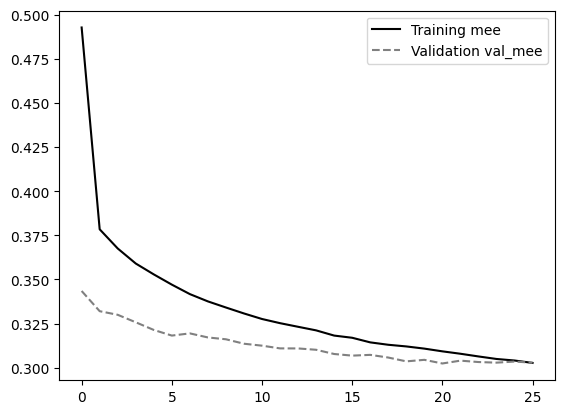

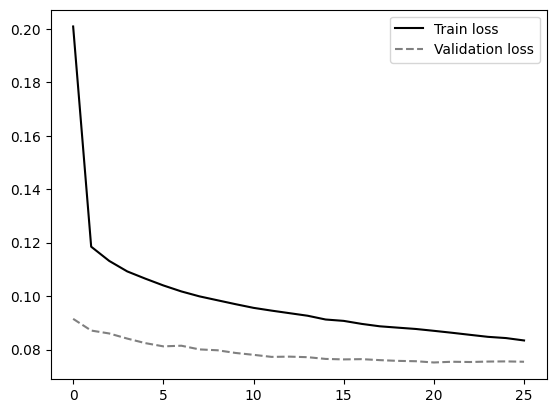

In [ ]:
model = grid_search(params, x_train, y_train, k_fold_val)

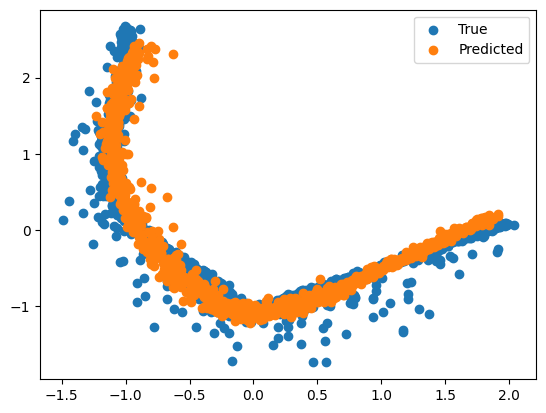

In [ ]:
y_pred = model(torch.from_numpy(x_train).to(torch.float32))
y_pred = y_pred.detach().numpy()


# y_train_rescaled = scaler.inverse_transform(y_train)
# print(y_train.shape)

plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label = "Predicted")
plt.legend()
plt.show()